In [242]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from numpy import argmax
import itertools



In [243]:
!git clone https://github.com/kecau/Multi-Output-model-for-Soccer.git

fatal: destination path 'Multi-Output-model-for-Soccer' already exists and is not an empty directory.


In [244]:
dataframe = pd.read_excel('/content/Multi-Output-model-for-Soccer/1_Data/Data.xlsx',  sheet_name = ['20-21','19-20', '18-19', '17-18', '16-17', '15-16', '14-15', '13-14', '12-13', '11-12', '10-11'])
dataframe = pd.concat(dataframe, axis= 0, ignore_index=True)

In [245]:
dataframe.columns

Index(['match_oder', 'oppense_team', 'FW0', 'FW0B', 'FW1', 'AMF0', 'AMF0B',
       'AMF1', 'AMF1B', 'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B',
       'CMF0C', 'CMF1', 'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1',
       'WB1B', 'CB0', 'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'Formation',
       'Opp_Level', 'Season', 'Ball_pos', 'Win', 'Style', 'sum'],
      dtype='object')

In [246]:
CSV_HEADER = ["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'Opp_Level', 'Season','Ball_pos','match_oder', 'oppense_team', 'Formation', 'Win', 'Style','sum']


CATEGORICAL_DATA = ['match_oder', 'oppense_team','Opp_Level', 'Season' ]


CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    feature_name: sorted([str(value) for value in list(dataframe[feature_name].unique())])
    for feature_name in CSV_HEADER
    if feature_name
    in list(CATEGORICAL_DATA)
}

NUMERIC_FEATURE_NAMES = ['Ball_pos']
BINARY_FEATURE_NAMES = ["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1']



FEATURE_NAMES = NUMERIC_FEATURE_NAMES + BINARY_FEATURE_NAMES + list(
    CATEGORICAL_FEATURES_WITH_VOCABULARY.keys()
)

In [247]:
dataframe_formation = dataframe['Formation'].unique().tolist()
dataframe_formation_to_encoded = {x: i for i, x in enumerate(dataframe_formation)}
dataframe_index_to_formation = {i: x for i, x in enumerate(dataframe_formation)}
dataframe['Formation'] = dataframe['Formation'].map(dataframe_formation_to_encoded)



win_cate = dataframe['Win'].unique().tolist()
win_to_encoded = {x: i for i, x in enumerate(win_cate)}
index_to_win = {i: x for i, x in enumerate(win_cate)} 
dataframe['Win'] = dataframe['Win'].map(win_to_encoded)


In [248]:
dataframe.dtypes

match_oder       object
oppense_team     object
FW0               int64
FW0B              int64
FW1               int64
AMF0              int64
AMF0B             int64
AMF1              int64
AMF1B             int64
Wing0             int64
Wing0B            int64
Wing1             int64
Wing1B            int64
CMF0              int64
CMF0B             int64
CMF0C             int64
CMF1              int64
CMF1B             int64
DMF0              int64
DMF1              int64
DMF1B             int64
WB0               int64
WB0B              int64
WB1               int64
WB1B              int64
CB0               int64
CB0B              int64
CB1               int64
CB1B              int64
GK0               int64
GK1               int64
Formation         int64
Opp_Level        object
Season           object
Ball_pos        float64
Win               int64
Style             int64
sum               int64
dtype: object

In [249]:
dataframe = dataframe.sample(frac=1, random_state=42)
dataframe

# # 10-11 ~ 19-20 시즌 - train
# train_dt = dataframe[dataframe['Season'] != '2020-2021']

# # 20-21 시즌 - test
# test_dt = dataframe[dataframe['Season'] == '2020-2021']

,match_oder,oppense_team,FW0,FW0B,FW1,AMF0,AMF0B,AMF1,AMF1B,Wing0,Wing0B,Wing1,Wing1B,CMF0,CMF0B,CMF0C,CMF1,CMF1B,DMF0,DMF1,DMF1B,WB0,WB0B,WB1,WB1B,CB0,CB0B,CB1,CB1B,GK0,GK1,Formation,Opp_Level,Season,Ball_pos,Win,Style,sum
321,18 round,Stoke City,1,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,26,Mid,2012-2013,63.2,2,0,11
324,21 round,Reading,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,26,Low,2012-2013,68.0,1,0,11
388,9 round,Everton,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,1,1,0,0,1,1,0,0,1,0,28,Mid,2010-2011,53.4,2,1,11
56,19 round,Brighton,1,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,1,1,0,1,0,11,Low,2019-2020,53.8,1,0,11
153,2 round,Crystal Palace,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,25,Mid,2016-2017,56.9,1,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,34 round,Bournemouth,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,2,Low,2019-2020,64.3,2,0,11
106,31 round,Crystal Palace,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,8,Mid,2018-2019,65.3,1,0,11
270,5 round,Cardiff City,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,8,Low,2013-2014,63.8,0,0,11
348,7 round,New castle,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,1,0,10,Mid,2011-2012,45.0,2,1,11


In [250]:
# 전체 데이터를 학습데이터로 해보기!
#####
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 16))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


# class GatedResidualNetwork(layers.Layer):
#     def __init__(self, units, dropout_rate):
#         super(GatedResidualNetwork, self).__init__()
#         self.units = units
#         self.elu_dense = layers.Dense(units, activation="elu")
#         self.linear_dense = layers.Dense(units)
#         self.dropout = layers.Dropout(dropout_rate)
#         self.gated_linear_unit = GatedLinearUnit(units)
#         self.layer_norm = layers.LayerNormalization()
#         self.project = layers.Dense(units)

#     def call(self, inputs):
#         x = self.elu_dense(inputs)
#         x = self.linear_dense(x)
#         x = self.dropout(x)
#         if inputs.shape[-1] != self.units:
#             inputs = self.project(inputs)
#         x = inputs + self.gated_linear_unit(x)
#         x = self.layer_norm(x)
#         return x    


# class VariableSelection(layers.Layer):
#     def __init__(self, num_features, units, dropout_rate):
#         super(VariableSelection, self).__init__()
#         self.grns = list()
#         # Create a GRN for each feature independently
#         for idx in range(num_features):
#             grn = GatedResidualNetwork(units, dropout_rate)
#             self.grns.append(grn)
#         # Create a GRN for the concatenation of all the features
#         self.grn_concat = GatedResidualNetwork(units, dropout_rate)
#         self.softmax = layers.Dense(units=num_features, activation="softmax")

#     def call(self, inputs):
#         v = layers.concatenate(inputs)
#         v = self.grn_concat(v)
#         v = tf.expand_dims(self.softmax(v), axis=-1)

#         x = []
#         for idx, input in enumerate(inputs):
#             x.append(self.grns[idx](input))
#         x = tf.stack(x, axis=1)

#         outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
#         return outputs


train_dataframe = dataframe.sample(380)
train_data = train_dataframe[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'Ball_pos']].values.astype(np.float)

train_data_cate = train_dataframe[['Opp_Level', 'Season','match_oder', 'oppense_team']].values

###test
test_dataframe = dataframe.sample(38)
test_data = test_dataframe[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'Ball_pos']].values.astype(np.float)

test_data_cate = test_dataframe[['Opp_Level', 'Season','match_oder', 'oppense_team']].values


y_formation = train_dataframe['Formation'].values
y_style = train_dataframe['Style'].values
y_win = train_dataframe['Win'].values


y_test_formation = test_dataframe['Formation'].values
y_test_style = test_dataframe['Style'].values
y_test_win = test_dataframe['Win'].values

In [251]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES + BINARY_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [252]:
def encode_inputs(inputs, encoding_size):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            index = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            # Convert the string input values into integer indices.
            value_index = index(inputs[feature_name])
            # Create an embedding layer with the specified dimensions
            embedding_ecoder = layers.Embedding(
                input_dim=len(vocabulary), output_dim=encoding_size
            )
            # Convert the index values to embedding representations.
            encoded_feature = embedding_ecoder(value_index)
        elif feature_name in NUMERIC_FEATURE_NAMES:
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)
            encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
            encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
            encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)

        else:
            # Project the numeric feature to encoding_size using linear transformation.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)
            encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
        encoded_features.append(encoded_feature)
    return encoded_features

In [253]:
def create_model(encoding_size):
  inputs = create_model_inputs()
  feature_list = encode_inputs(inputs, encoding_size)
  concat = layers.concatenate(feature_list)

  x_1_input = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_1 = layers.BatchNormalization()(x_1_input)
  x_1 = layers.Dropout(dropout_rate)(x_1)
  x_1 = layers.ReLU()(x_1)
  x_1 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(x_1) + x_1_input
  output_for = layers.Dense(31, activation='softmax', name='output_for')(x_1)

  x_2_input = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_2 = layers.BatchNormalization()(x_2_input)
  x_2 = layers.Dropout(dropout_rate)(x_2)
  x_2 = layers.ReLU()(x_2)
  x_2 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(x_2) + x_2_input
  output_style = layers.Dense(2, activation='softmax', name='output_style')(x_2)

  x_3_input = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_3 = layers.BatchNormalization()(x_3_input)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(x_3) + x_3_input
  x_3 = layers.Dense(24, kernel_regularizer=keras.regularizers.l2(0.001))(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dense(12)(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.ReLU()(x_3)
  output_win = layers.Dense(3, activation='softmax', name='output_win')(x_3)

  model = keras.Model(inputs=inputs, outputs = [output_for, output_style, output_win])
  return model


In [254]:
learning_rate = 0.01
dropout_rate = 0.20
num_epochs = 100
encoding_size = 16

In [255]:
model = create_model(encoding_size=encoding_size) 

In [256]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss= {'output_for': keras.losses.SparseCategoricalCrossentropy(), 
                      'output_win':keras.losses.SparseCategoricalCrossentropy(), 
                      'output_style':keras.losses.SparseCategoricalCrossentropy()},
              metrics =  {'output_for': [keras.metrics.SparseCategoricalAccuracy()],
                      'output_win':[keras.metrics.SparseCategoricalAccuracy()], 
                      'output_style':[keras.metrics.SparseCategoricalAccuracy()] }
              
              # {'output_for': [keras.losses.SparseCategoricalCrossentropy() ,keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')],
              #         'output_win':[keras.losses.SparseCategoricalCrossentropy(),keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')], 
              #         'output_style':[keras.losses.SparseCategoricalCrossentropy() ,keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')]}
)

In [257]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience= 15, restore_best_weights=True)

In [258]:
history = model.fit(x={
    'FW0': train_data[:, 0:1],
    'FW0B':train_data[:, 1:2],
    "FW1" :train_data[:, 2:3],
    'AMF0':train_data[:, 3:4],
    'AMF0B':train_data[:, 4:5],
    'AMF1':train_data[:, 5:6],
    'AMF1B':train_data[:, 6:7],
    'Wing0':train_data[:, 7:8],
    'Wing0B':train_data[:, 8:9],
    'Wing1':train_data[:, 9:10],
    'Wing1B':train_data[:, 10:11],
    'CMF0':train_data[:, 11:12],
    'CMF0B':train_data[:, 12:13],
    'CMF0C':train_data[:, 13:14],
    'CMF1':train_data[:, 14:15],
    'CMF1B':train_data[:, 15:16],
    'DMF0':train_data[:, 16:17],
    'DMF1':train_data[:, 17:18],
    'DMF1B':train_data[:, 18:19],
    'WB0':train_data[:, 19:20],
    'WB0B':train_data[:, 20:21],
    'WB1':train_data[:, 21:22],
    'WB1B':train_data[:, 22:23],
    'CB0':train_data[:, 23:24],
    'CB0B':train_data[:, 24:25],
    'CB1':train_data[:, 25:26],
    'CB1B':train_data[:, 26:27],
    'GK0':train_data[:, 27:28],
    'GK1':train_data[:, 28:29],
    'Ball_pos':train_data[:, 29:30],

    'Opp_Level':train_data_cate[:, 0:1],
    'Season':train_data_cate[:, 1:2],
    'match_oder':train_data_cate[:, 2:3],
    'oppense_team':train_data_cate[:, 3:4],
    }, 
    y = {'output_for': y_formation, 
         'output_style': y_style,
         'output_win':y_win}, 
         epochs=num_epochs, 
         validation_split=0.05 , 
         callbacks=[early_stop])

Epoch 1/100
12/12 [==============================] - 7s 139ms/step - loss: 6.1160 - output_for_loss: 2.7352 - output_style_loss: 1.7224 - output_win_loss: 1.2647 - output_for_sparse_categorical_accuracy: 0.4266 - output_style_sparse_categorical_accuracy: 0.6482 - output_win_sparse_categorical_accuracy: 0.3490 - val_loss: 11.0232 - val_output_for_loss: 1.7334 - val_output_style_loss: 7.7193 - val_output_win_loss: 1.1477 - val_output_for_sparse_categorical_accuracy: 0.6316 - val_output_style_sparse_categorical_accuracy: 0.2632 - val_output_win_sparse_categorical_accuracy: 0.6316
Epoch 2/100
12/12 [==============================] - 0s 20ms/step - loss: 3.1017 - output_for_loss: 1.1821 - output_style_loss: 0.3949 - output_win_loss: 1.0812 - output_for_sparse_categorical_accuracy: 0.6925 - output_style_sparse_categorical_accuracy: 0.8670 - output_win_sparse_categorical_accuracy: 0.4571 - val_loss: 9.1726 - val_output_for_loss: 1.1177 - val_output_style_loss: 6.5847 - val_output_win_loss: 1.

In [259]:
model.evaluate(x={
    'FW0': test_data[:, 0:1],
    'FW0B':test_data[:, 1:2],
    "FW1" :test_data[:, 2:3],
    'AMF0':test_data[:, 3:4],
    'AMF0B':test_data[:, 4:5],
    'AMF1':test_data[:, 5:6],
    'AMF1B':test_data[:, 6:7],
    'Wing0':test_data[:, 7:8],
    'Wing0B':test_data[:, 8:9],
    'Wing1':test_data[:, 9:10],
    'Wing1B':test_data[:, 10:11],
    'CMF0':test_data[:, 11:12],
    'CMF0B':test_data[:, 12:13],
    'CMF0C':test_data[:, 13:14],
    'CMF1':test_data[:, 14:15],
    'CMF1B':test_data[:, 15:16],
    'DMF0':test_data[:, 16:17],
    'DMF1':test_data[:, 17:18],
    'DMF1B':test_data[:, 18:19],
    'WB0':test_data[:, 19:20],
    'WB0B':test_data[:, 20:21],
    'WB1':test_data[:, 21:22],
    'WB1B':test_data[:, 22:23],
    'CB0':test_data[:, 23:24],
    'CB0B':test_data[:, 24:25],
    'CB1':test_data[:, 25:26],
    'CB1B':test_data[:, 26:27],
    'GK0':test_data[:, 27:28],
    'GK1':test_data[:, 28:29],
    'Ball_pos':test_data[:, 29:30],

    'Opp_Level':test_data_cate[:, 0:1],
    'Season':test_data_cate[:, 1:2],
    'match_oder':test_data_cate[:, 2:3],
    'oppense_team':test_data_cate[:, 3:4],
    }, 
    y = {'output_for': y_test_formation, 
         'output_style': y_test_style,
         'output_win':y_test_win})

2/2 [==============================] - 0s 12ms/step - loss: 1.0340 - output_for_loss: 0.0191 - output_style_loss: 0.0503 - output_win_loss: 0.5368 - output_for_sparse_categorical_accuracy: 1.0000 - output_style_sparse_categorical_accuracy: 1.0000 - output_win_sparse_categorical_accuracy: 0.7895


[1.034044623374939,
 0.019139613956212997,
 0.050300706177949905,
 0.536837637424469,
 1.0,
 1.0,
 0.7894737124443054]

In [260]:
dataframe

test_dt = dataframe[dataframe['Season'] == '2020-2021']

###test
#test_dataframe = dataframe.sample(38)
test_data = test_dt[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'Ball_pos']].values.astype(np.float)

test_data_cate = test_dt[['Opp_Level', 'Season','match_oder', 'oppense_team']].values

y_test_formation = test_dt['Formation'].values
y_test_style = test_dt['Style'].values
y_test_win = test_dt['Win'].values

In [261]:
#### 데이터 검증방법, 여기서부터 시작하기! 

In [262]:
from sklearn.model_selection import train_test_split # holdout - validation
from sklearn.model_selection import KFold # k-flod 크로스 벨리데이션 
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold


In [284]:
dataframe = dataframe.sample(frac=1, random_state=None,)
dataframe.head()

,match_oder,oppense_team,FW0,FW0B,FW1,AMF0,AMF0B,AMF1,AMF1B,Wing0,Wing0B,Wing1,Wing1B,CMF0,CMF0B,CMF0C,CMF1,CMF1B,DMF0,DMF1,DMF1B,WB0,WB0B,WB1,WB1B,CB0,CB0B,CB1,CB1B,GK0,GK1,Formation,Opp_Level,Season,Ball_pos,Win,Style,sum
325,22 round,QPR,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,26,Low,2012-2013,61.9,2,0,11
369,28 round,Everton,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,3,Mid,2011-2012,62.1,0,0,11
220,31 round,Bournemouth,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,8,Low,2015-2016,62.8,1,0,11
53,16 round,Burnley,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,8,Mid,2019-2020,49.0,1,1,11
60,23 round,Watford,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,13,Low,2019-2020,58.5,2,0,11


In [285]:
#### hold out 방법
dataframe1 = dataframe[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'Ball_pos']].astype(np.float)

dataframe2 = dataframe[['Opp_Level', 'Season','match_oder', 'oppense_team', 'Formation', 'Style', 'Win']]
df_cat = pd.concat([dataframe1, dataframe2], axis=1)

x1 = df_cat.drop(['Formation', 'Style', 'Win'], axis=1).values
y1 = df_cat[['Formation', 'Style', 'Win']].values



------------------------------------------------------------------------
Training for hold 1 ...
Epoch 1/100
12/12 [==============================] - 6s 108ms/step - loss: 7.8195 - output_for_loss: 3.3166 - output_style_loss: 2.8871 - output_win_loss: 1.2075 - output_for_sparse_categorical_accuracy: 0.4247 - output_style_sparse_categorical_accuracy: 0.5134 - output_win_sparse_categorical_accuracy: 0.4435 - val_loss: 5.7192 - val_output_for_loss: 3.3214 - val_output_style_loss: 0.9477 - val_output_win_loss: 1.0081 - val_output_for_sparse_categorical_accuracy: 0.0000e+00 - val_output_style_sparse_categorical_accuracy: 0.5000 - val_output_win_sparse_categorical_accuracy: 0.7500
Epoch 2/100
12/12 [==============================] - 0s 16ms/step - loss: 3.3522 - output_for_loss: 1.2937 - output_style_loss: 0.5640 - output_win_loss: 1.0328 - output_for_sparse_categorical_accuracy: 0.6962 - output_style_sparse_categorical_accuracy: 0.7500 - output_win_sparse_categorical_accuracy: 0.5242 - val_

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         1
           3       0.50      0.50      0.50         2
           7       1.00      1.00      1.00         3
           8       0.93      1.00      0.96        13
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         2
          11       0.50      0.50      0.50         2
          12       1.00      1.00      1.00         1
          15       1.00      0.50      0.67         2
          16       0.00      0.00      0.00         1
          17       0.67      1.00      0.80         2
          25       1.00      1.00      1.00         1
          26       1.00      1.00      1.00         1
          27       1.00      1.00      1.00         1

    accuracy                           0.90        42
   macro avg       0.84      0.83      0.83        42
weighted avg       0.89   

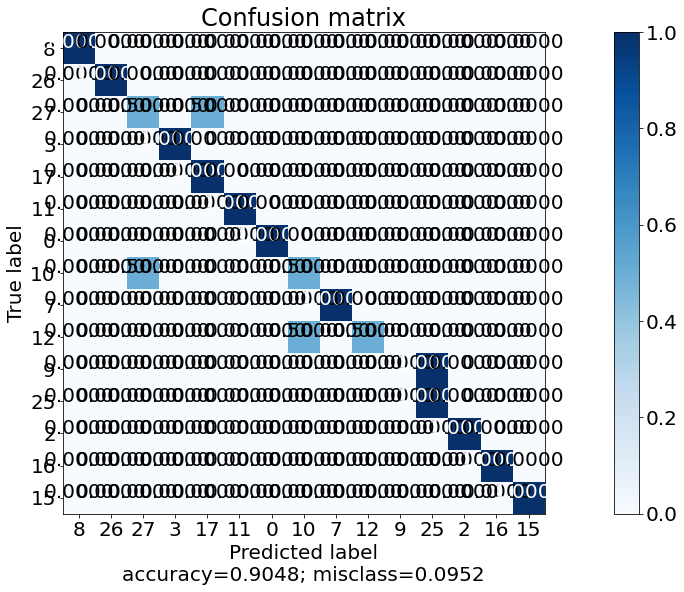

------------------------------------------------------------------------
Training for hold 2 ...
Epoch 1/100
12/12 [==============================] - 0s 30ms/step - loss: 1.2904 - output_for_loss: 0.1939 - output_style_loss: 0.0740 - output_win_loss: 0.6745 - output_for_sparse_categorical_accuracy: 0.9677 - output_style_sparse_categorical_accuracy: 0.9839 - output_win_sparse_categorical_accuracy: 0.7500 - val_loss: 2.4946 - val_output_for_loss: 0.0148 - val_output_style_loss: 1.6840 - val_output_win_loss: 0.4448 - val_output_for_sparse_categorical_accuracy: 1.0000 - val_output_style_sparse_categorical_accuracy: 0.7500 - val_output_win_sparse_categorical_accuracy: 0.7500
Epoch 2/100
12/12 [==============================] - 0s 18ms/step - loss: 1.1467 - output_for_loss: 0.1385 - output_style_loss: 0.0398 - output_win_loss: 0.6085 - output_for_sparse_categorical_accuracy: 0.9624 - output_style_sparse_categorical_accuracy: 0.9866 - output_win_sparse_categorical_accuracy: 0.7554 - val_loss:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00        18
           9       0.00      0.00      0.00         0
          17       1.00      1.00      1.00         1
          20       1.00      1.00      1.00         1
          25       0.00      0.00      0.00         1
          26       1.00      1.00      1.00         2
          27       0.00      0.00      0.00         1
          28       1.00      1.00      1.00         3

    accuracy                           0.95        42
   macro avg       0.73      0.75      0.74        42
weighted avg       0.93      0.95      0.94        42

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00 

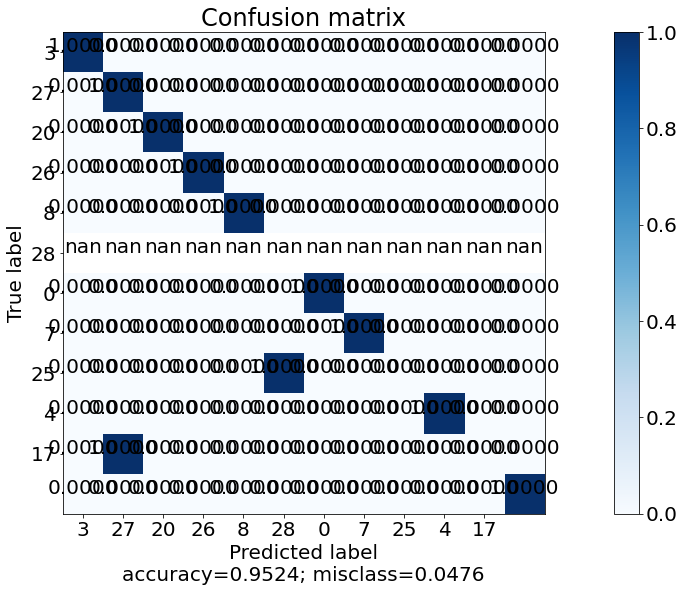

------------------------------------------------------------------------
Training for hold 3 ...
Epoch 1/100
12/12 [==============================] - 0s 33ms/step - loss: 1.1246 - output_for_loss: 0.0461 - output_style_loss: 0.0897 - output_win_loss: 0.6005 - output_for_sparse_categorical_accuracy: 0.9892 - output_style_sparse_categorical_accuracy: 0.9731 - output_win_sparse_categorical_accuracy: 0.7715 - val_loss: 1.8274 - val_output_for_loss: 0.5072 - val_output_style_loss: 0.1808 - val_output_win_loss: 0.7481 - val_output_for_sparse_categorical_accuracy: 0.7500 - val_output_style_sparse_categorical_accuracy: 1.0000 - val_output_win_sparse_categorical_accuracy: 0.5000
Epoch 2/100
12/12 [==============================] - 0s 16ms/step - loss: 1.1569 - output_for_loss: 0.0995 - output_style_loss: 0.1557 - output_win_loss: 0.5091 - output_for_sparse_categorical_accuracy: 0.9704 - output_style_sparse_categorical_accuracy: 0.9435 - output_win_sparse_categorical_accuracy: 0.8387 - val_loss:

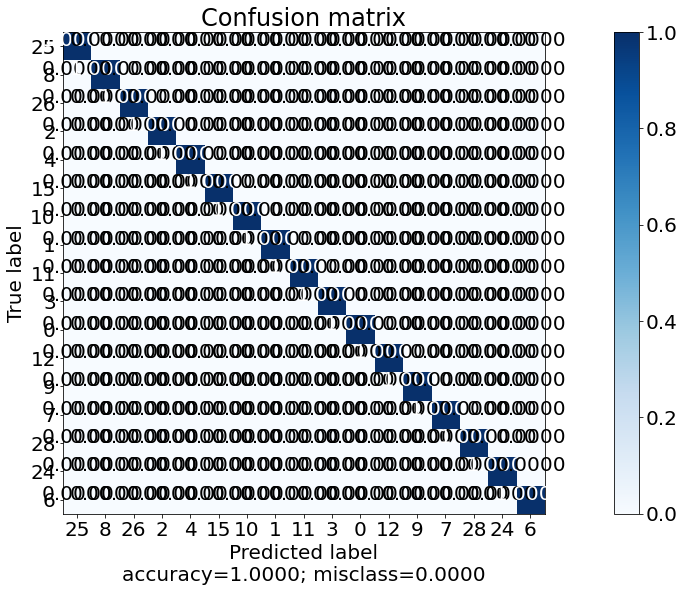

------------------------------------------------------------------------
Training for hold 4 ...
Epoch 1/100
12/12 [==============================] - 0s 29ms/step - loss: 1.0904 - output_for_loss: 0.1042 - output_style_loss: 0.0725 - output_win_loss: 0.5236 - output_for_sparse_categorical_accuracy: 0.9704 - output_style_sparse_categorical_accuracy: 0.9704 - output_win_sparse_categorical_accuracy: 0.7823 - val_loss: 1.4150 - val_output_for_loss: 0.0010 - val_output_style_loss: 1.4280e-04 - val_output_win_loss: 1.0248 - val_output_for_sparse_categorical_accuracy: 1.0000 - val_output_style_sparse_categorical_accuracy: 1.0000 - val_output_win_sparse_categorical_accuracy: 0.7500
Epoch 2/100
12/12 [==============================] - 0s 18ms/step - loss: 1.1149 - output_for_loss: 0.1105 - output_style_loss: 0.1076 - output_win_loss: 0.5080 - output_for_sparse_categorical_accuracy: 0.9651 - output_style_sparse_categorical_accuracy: 0.9624 - output_win_sparse_categorical_accuracy: 0.8091 - val_l

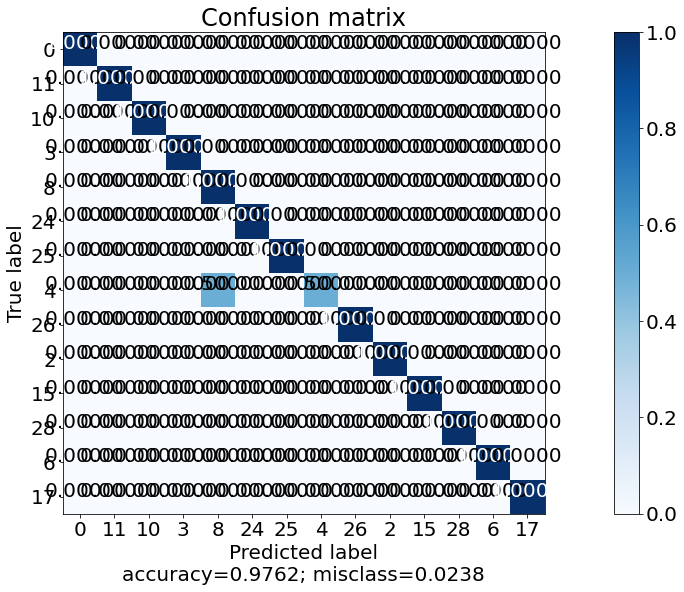

------------------------------------------------------------------------
Training for hold 5 ...
Epoch 1/100
12/12 [==============================] - 0s 30ms/step - loss: 1.0988 - output_for_loss: 0.0865 - output_style_loss: 0.1668 - output_win_loss: 0.4395 - output_for_sparse_categorical_accuracy: 0.9677 - output_style_sparse_categorical_accuracy: 0.9409 - output_win_sparse_categorical_accuracy: 0.8360 - val_loss: 18.1211 - val_output_for_loss: 0.0127 - val_output_style_loss: 17.6590 - val_output_win_loss: 0.0461 - val_output_for_sparse_categorical_accuracy: 1.0000 - val_output_style_sparse_categorical_accuracy: 0.2500 - val_output_win_sparse_categorical_accuracy: 1.0000
Epoch 2/100
12/12 [==============================] - 0s 18ms/step - loss: 1.0412 - output_for_loss: 0.0489 - output_style_loss: 0.0908 - output_win_loss: 0.5008 - output_for_sparse_categorical_accuracy: 0.9812 - output_style_sparse_categorical_accuracy: 0.9570 - output_win_sparse_categorical_accuracy: 0.8038 - val_los

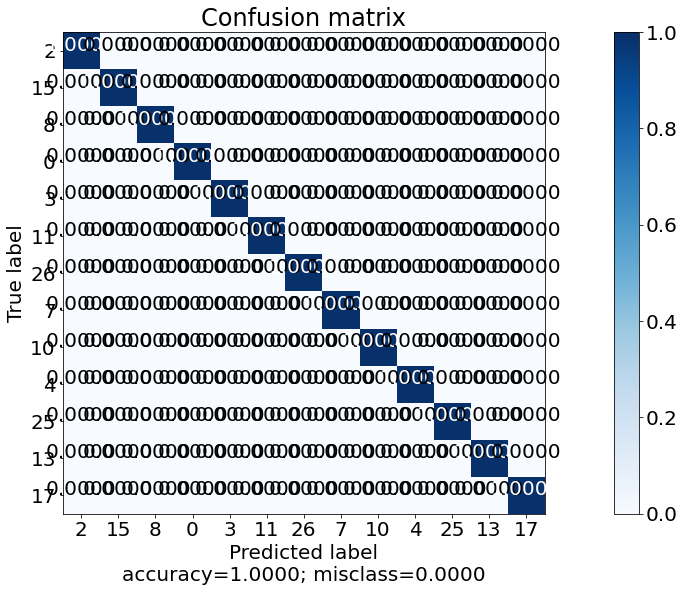



Averages
Accuracy_formation: 0.9666666666666668
Accuracy_style: 0.919047619047619
Accuracy_win: 0.6333333333333334
Precision_formation: 0.9666666666666668
Precision_style: 0.8965686274509803
Precision_win: 0.6333333333333334
Recall_formation: 0.9666666666666668
Recall_style: 0.958119658119658
Recall_win: 0.07619047619047618
Style Confusion Matrix

[[21.2  2.4]
 [ 1.  17.4]]


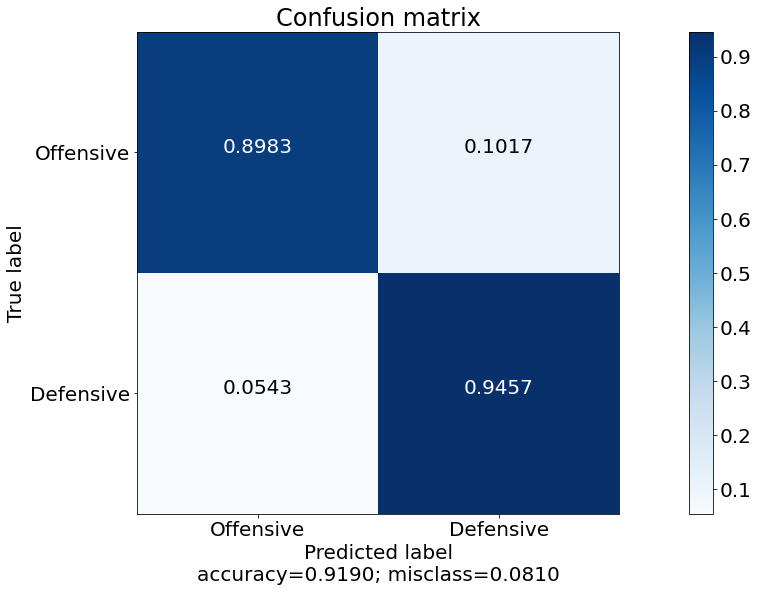

Win Confusion Matrix

[[ 8.2  2.6  0.8]
 [ 4.6 14.8  2.2]
 [ 2.4  2.8  3.6]]


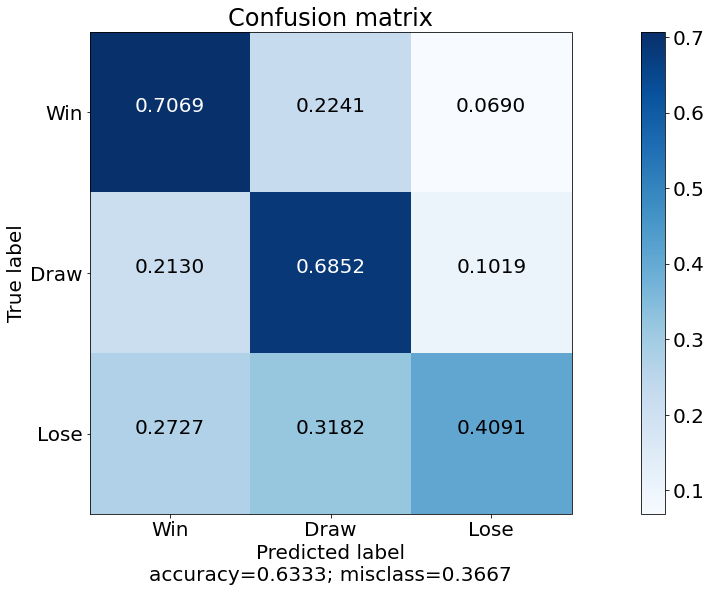

In [312]:
# Holdout Validation Approach - Train and Test Set Split

hold_no = 1
acc_per_hold = []
loss_per_hold = []

cfmean_for = []
cfmean_style = []
cfmean_win = []
accmean_for = []
accmean_style = []
accmean_win = []
precmean_for = []
precmean_style = []
precmean_win = []
recmean_for = []
recmean_style = []
recmean_win = []



early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience= 15, restore_best_weights=True)

model = create_model(encoding_size=encoding_size) 

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
            loss= {'output_for': keras.losses.SparseCategoricalCrossentropy(), 
                    'output_win':keras.losses.SparseCategoricalCrossentropy(), 
                    'output_style':keras.losses.SparseCategoricalCrossentropy()},
            metrics =  {'output_for': [keras.metrics.SparseCategoricalAccuracy()],
                    'output_win':[keras.metrics.SparseCategoricalAccuracy()], 
                    'output_style':[keras.metrics.SparseCategoricalAccuracy()] })


for i in range(5):

  X_train, X_test, Y_train, Y_test = train_test_split(x1, y1, test_size=0.1)
                                                      #randomstate = 41)

  X_train_num = X_train[:, :30].astype(np.float)
  X_train_obj = X_train[:, 30:]

  X_test_num = X_test[:, :30].astype(np.float)
  X_test_obj = X_test[:, 30:]
                



  print('------------------------------------------------------------------------')
  print(f'Training for hold {hold_no} ...')

  history = model.fit(x={
    'FW0': X_train_num[:, 0:1],
    'FW0B':X_train_num[:, 1:2],
    "FW1" :X_train_num[:, 2:3],
    'AMF0':X_train_num[:, 3:4],
    'AMF0B':X_train_num[:, 4:5],
    'AMF1':X_train_num[:, 5:6],
    'AMF1B':X_train_num[:, 6:7],
    'Wing0':X_train_num[:, 7:8],
    'Wing0B':X_train_num[:, 8:9],
    'Wing1':X_train_num[:, 9:10],
    'Wing1B':X_train_num[:, 10:11],
    'CMF0':X_train_num[:, 11:12],
    'CMF0B':X_train_num[:, 12:13],
    'CMF0C':X_train_num[:, 13:14],
    'CMF1':X_train_num[:, 14:15],
    'CMF1B':X_train_num[:, 15:16],
    'DMF0':X_train_num[:, 16:17],
    'DMF1':X_train_num[:, 17:18],
    'DMF1B':X_train_num[:, 18:19],
    'WB0':X_train_num[:, 19:20],
    'WB0B':X_train_num[:, 20:21],
    'WB1':X_train_num[:, 21:22],
    'WB1B':X_train_num[:, 22:23],
    'CB0':X_train_num[:, 23:24],
    'CB0B':X_train_num[:, 24:25],
    'CB1':X_train_num[:, 25:26],
    'CB1B':X_train_num[:, 26:27],
    'GK0':X_train_num[:, 27:28],
    'GK1':X_train_num[:, 28:29],
    'Ball_pos':X_train_num[:, 29:30],

    'Opp_Level':X_train_obj[:, 0:1],
    'Season':X_train_obj[:, 1:2],
    'match_oder':X_train_obj[:, 2:3],
    'oppense_team':X_train_obj[:, 3:4],
    }, 
    y = {'output_for': Y_train[:, 0], 
         'output_style': Y_train[:, 1],
         'output_win':Y_train[:, 2]}, 
         
         epochs=num_epochs, 
         validation_split=0.01 , 
         callbacks=[early_stop])
  
  # Generate generalization metrics
  scores_hold = model.evaluate(x={
    'FW0': X_test_num[:, 0:1],
    'FW0B':X_test_num[:, 1:2],
    "FW1" :X_test_num[:, 2:3],
    'AMF0':X_test_num[:, 3:4],
    'AMF0B':X_test_num[:, 4:5],
    'AMF1':X_test_num[:, 5:6],
    'AMF1B':X_test_num[:, 6:7],
    'Wing0':X_test_num[:, 7:8],
    'Wing0B':X_test_num[:, 8:9],
    'Wing1':X_test_num[:, 9:10],
    'Wing1B':X_test_num[:, 10:11],
    'CMF0':X_test_num[:, 11:12],
    'CMF0B':X_test_num[:, 12:13],
    'CMF0C':X_test_num[:, 13:14],
    'CMF1':X_test_num[:, 14:15],
    'CMF1B':X_test_num[:, 15:16],
    'DMF0':X_test_num[:, 16:17],
    'DMF1':X_test_num[:, 17:18],
    'DMF1B':X_test_num[:, 18:19],
    'WB0':X_test_num[:, 19:20],
    'WB0B':X_test_num[:, 20:21],
    'WB1':X_test_num[:, 21:22],
    'WB1B':X_test_num[:, 22:23],
    'CB0':X_test_num[:, 23:24],
    'CB0B':X_test_num[:, 24:25],
    'CB1':X_test_num[:, 25:26],
    'CB1B':X_test_num[:, 26:27],
    'GK0':X_test_num[:, 27:28],
    'GK1':X_test_num[:, 28:29],
    'Ball_pos':X_test_num[:, 29:30],

    'Opp_Level':X_test_obj[:, 0:1],
    'Season':X_test_obj[:, 1:2],
    'match_oder':X_test_obj[:, 2:3],
    'oppense_team':X_test_obj[:, 3:4],
    }, 
    y = {'output_for': Y_test[:, 0], 
         'output_style': Y_test[:, 1],
         'output_win':Y_test[:, 2]})
  

  print(f'Score for hold {hold_no}: {model.metrics_names[0]} of {scores_hold[0]}; {model.metrics_names[4]} of {scores_hold[4]*100}%; {model.metrics_names[5]} of {scores_hold[5]*100}%\
  ; {model.metrics_names[6]} of {scores_hold[6]*100}%')

  acc_per_hold.append([scores_hold[4] * 100, scores_hold[5] * 100, scores_hold[6] * 100])
  loss_per_hold.append(scores_hold[0])

  # Increase fold number
  hold_no = hold_no + 1

  y_pred = model.predict(x={
    'FW0': X_test_num[:, 0:1],
    'FW0B':X_test_num[:, 1:2],
    "FW1" :X_test_num[:, 2:3],
    'AMF0':X_test_num[:, 3:4],
    'AMF0B':X_test_num[:, 4:5],
    'AMF1':X_test_num[:, 5:6],
    'AMF1B':X_test_num[:, 6:7],
    'Wing0':X_test_num[:, 7:8],
    'Wing0B':X_test_num[:, 8:9],
    'Wing1':X_test_num[:, 9:10],
    'Wing1B':X_test_num[:, 10:11],
    'CMF0':X_test_num[:, 11:12],
    'CMF0B':X_test_num[:, 12:13],
    'CMF0C':X_test_num[:, 13:14],
    'CMF1':X_test_num[:, 14:15],
    'CMF1B':X_test_num[:, 15:16],
    'DMF0':X_test_num[:, 16:17],
    'DMF1':X_test_num[:, 17:18],
    'DMF1B':X_test_num[:, 18:19],
    'WB0':X_test_num[:, 19:20],
    'WB0B':X_test_num[:, 20:21],
    'WB1':X_test_num[:, 21:22],
    'WB1B':X_test_num[:, 22:23],
    'CB0':X_test_num[:, 23:24],
    'CB0B':X_test_num[:, 24:25],
    'CB1':X_test_num[:, 25:26],
    'CB1B':X_test_num[:, 26:27],
    'GK0':X_test_num[:, 27:28],
    'GK1':X_test_num[:, 28:29],
    'Ball_pos':X_test_num[:, 29:30],

    'Opp_Level':X_test_obj[:, 0:1],
    'Season':X_test_obj[:, 1:2],
    'match_oder':X_test_obj[:, 2:3],
    'oppense_team':X_test_obj[:, 3:4],
    })
  
  pred_for = []
  pred_style = []
  pred_win = []

  for i in y_pred[0:1][0]:
    pred_for.append(argmax(i))

  for i in y_pred[1:2][0]:
    pred_style.append(argmax(i))

  for i in y_pred[2:3][0]:
    pred_win.append(argmax(i))

  
  accmean_for.append(accuracy_score(Y_test[:, 0], pred_for))
  accmean_style.append(accuracy_score(Y_test[:, 1], pred_style))
  accmean_win.append(accuracy_score(Y_test[:, 2], pred_win))

  precmean_for.append(precision_score(Y_test[:, 0], pred_for, average='micro'))
  precmean_style.append(precision_score(Y_test[:, 1], pred_style, average='binary'))
  precmean_win.append(precision_score(Y_test[:, 2], pred_win, average='micro'))

  recmean_for.append(recall_score(Y_test[:, 0], pred_for, average='micro'))
  recmean_style.append(recall_score(Y_test[:, 1], pred_style, average='binary'))
  recmean_win.append(recall_score(Y_test[:, 2], pred_for, average='micro'))

  print(classification_report(Y_test[:, 0], pred_for, ))
  print(classification_report(Y_test[:, 1], pred_style, ))
  print(classification_report(Y_test[:, 2], pred_win, ))

  cfmean_for.append(confusion_matrix(Y_test[:, 0], pred_for))
  cfmean_style.append(confusion_matrix(Y_test[:, 1], pred_style))
  cfmean_win.append(confusion_matrix(Y_test[:, 2], pred_win))

  plot_confusion_matrix(confusion_matrix(Y_test[:, 0], pred_for), normalize=True, target_names=pd.Series(Y_test[:, 0]).unique().tolist() )
  #confusion_matrix(Y_test[:, 0], pred_for)


acc_for = np.mean(accmean_for, axis=0)
acc_style = np.mean(accmean_style, axis=0)
acc_win = np.mean(accmean_win, axis=0)

pre_for = np.mean(precmean_for, axis=0)
pre_style = np.mean(precmean_style, axis=0)
pre_win = np.mean(precmean_win, axis=0)

#cm_for = np.mean(cfmean_for, axis=0)
cm_style = np.mean(cfmean_style, axis=0)
cm_win = np.mean(cfmean_win, axis=0)

re_for = np.mean(recmean_for, axis=0)
re_style = np.mean(recmean_style, axis=0)
re_win = np.mean(recmean_win, axis=0)

print('\n')
print("Averages")
print("Accuracy_formation: " + str(acc_for))
print("Accuracy_style: " + str(acc_style))
print("Accuracy_win: " + str(acc_win))

print("Precision_formation: " + str(pre_for))
print("Precision_style: " + str(pre_style))
print("Precision_win: " + str(pre_win))

print("Recall_formation: " + str(re_for))
print("Recall_style: " + str(re_style))
print("Recall_win: " + str(re_win))



print('Style Confusion Matrix\n')
print(cm_style)

plot_confusion_matrix(cm_style, normalize=True, target_names= ['Offensive', 'Defensive'] )

print('Win Confusion Matrix\n')
print(cm_win)

plot_confusion_matrix(cm_win, normalize=True, target_names= ['Win', 'Draw', 'Lose'] )





In [273]:
# K-fold cross validation 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

dataframe1 = dataframe[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'Ball_pos']].astype(np.float)

dataframe2 = dataframe[['Opp_Level', 'Season','match_oder', 'oppense_team', 'Formation', 'Style', 'Win']]
df_cat = pd.concat([dataframe1, dataframe2], axis=1)

x1 = df_cat.drop(['Formation', 'Style', 'Win'], axis=1).values
y1 = df_cat[['Formation', 'Style', 'Win']].values

In [274]:
model = create_model(encoding_size=encoding_size) 

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
            loss= {'output_for': keras.losses.SparseCategoricalCrossentropy(), 
                    'output_win':keras.losses.SparseCategoricalCrossentropy(), 
                    'output_style':keras.losses.SparseCategoricalCrossentropy()},
            metrics =  {'output_for': [keras.metrics.SparseCategoricalAccuracy()],
                    'output_win':[keras.metrics.SparseCategoricalAccuracy()], 
                    'output_style':[keras.metrics.SparseCategoricalAccuracy()] })

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
11/11 [==============================] - 8s 161ms/step - loss: 8.5973 - output_for_loss: 3.9852 - output_style_loss: 2.7315 - output_win_loss: 1.4824 - output_for_sparse_categorical_accuracy: 0.3667 - output_style_sparse_categorical_accuracy: 0.6121 - output_win_sparse_categorical_accuracy: 0.3061 - val_loss: 10.8785 - val_output_for_loss: 1.7976 - val_output_style_loss: 6.1048 - val_output_win_loss: 2.5477 - val_output_for_sparse_categorical_accuracy: 0.5000 - val_output_style_sparse_categorical_accuracy: 0.5000 - val_output_win_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 0s 20ms/step - loss: 3.2053 - output_for_loss: 1.1985 - output_style_loss: 0.3804 - output_win_loss: 1.1764 - output_for_sparse_categorical_accuracy: 0.6909 - output_style_sparse_categorical_accuracy: 0.8606 - output_win_sparse_categorical_accuracy: 0.3848 - val

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         3
           3       0.50      0.60      0.55         5
           4       1.00      1.00      1.00         7
           6       0.00      0.00      0.00         1
           7       1.00      0.67      0.80         3
           8       0.96      0.92      0.94        26
           9       0.00      0.00      0.00         1
          10       1.00      0.67      0.80         3
          11       0.40      1.00      0.57         2
          12       1.00      0.33      0.50         3
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          15       1.00      1.00      1.00         1
          17       0.67      1.00      0.80         2
          18       0.00      0.00      0.00         0
          19       0.00    

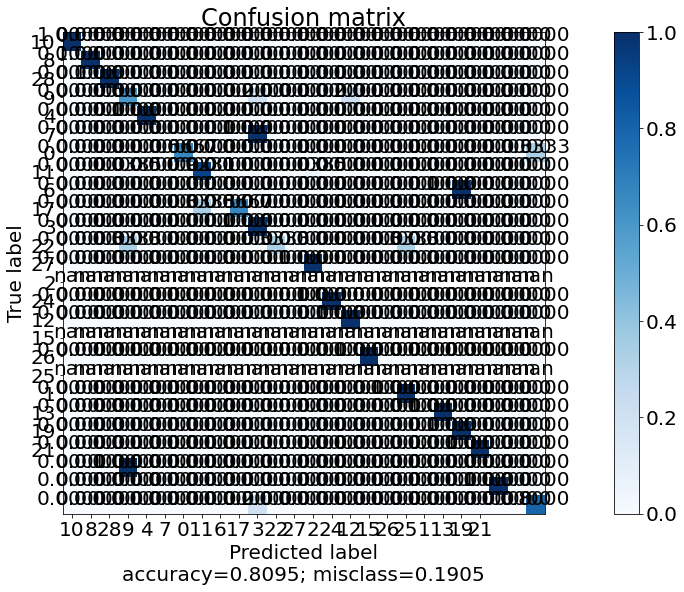

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
11/11 [==============================] - 0s 35ms/step - loss: 1.6540 - output_for_loss: 0.2621 - output_style_loss: 0.1948 - output_win_loss: 0.8046 - output_for_sparse_categorical_accuracy: 0.9576 - output_style_sparse_categorical_accuracy: 0.9455 - output_win_sparse_categorical_accuracy: 0.7485 - val_loss: 1.7603 - val_output_for_loss: 0.2360 - val_output_style_loss: 0.0210 - val_output_win_loss: 1.0983 - val_output_for_sparse_categorical_accuracy: 1.0000 - val_output_style_sparse_categorical_accuracy: 1.0000 - val_output_win_sparse_categorical_accuracy: 0.2500
Epoch 2/100
11/11 [==============================] - 0s 17ms/step - loss: 1.3004 - output_for_loss: 0.1135 - output_style_loss: 0.1045 - output_win_loss: 0.6706 - output_for_sparse_categorical_accuracy: 0.9788 - output_style_sparse_categorical_accuracy: 0.9576 - output_win_sparse_categorical_accuracy: 0.7303 - val_loss:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         1
           3       0.60      1.00      0.75         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00        34
           9       0.50      1.00      0.67         1
          10       1.00      1.00      1.00         2
          11       1.00      0.83      0.91         6
          15       1.00      1.00      1.00         2
          17       0.50      1.00      0.67         1
          18       0.00      0.00      0.00         1
          19       1.00      1.00      1.00         1
          22       1.00      1.00      1.00         1
          25       1.00      1.00      1.00         1
          26       1.00      1.00      1.00         3
          27       0.00    

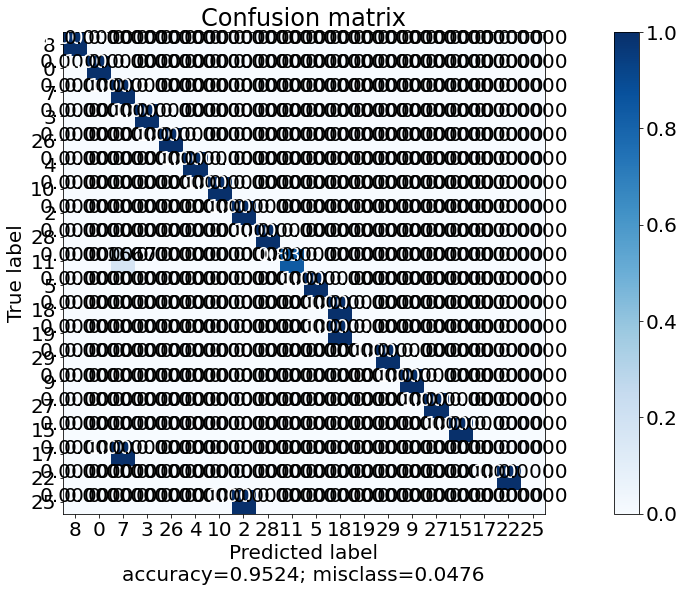

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
11/11 [==============================] - 0s 30ms/step - loss: 1.1969 - output_for_loss: 0.1395 - output_style_loss: 0.0455 - output_win_loss: 0.6643 - output_for_sparse_categorical_accuracy: 0.9818 - output_style_sparse_categorical_accuracy: 0.9879 - output_win_sparse_categorical_accuracy: 0.8091 - val_loss: 2.1107 - val_output_for_loss: 0.2290 - val_output_style_loss: 0.0091 - val_output_win_loss: 1.5211 - val_output_for_sparse_categorical_accuracy: 0.7500 - val_output_style_sparse_categorical_accuracy: 1.0000 - val_output_win_sparse_categorical_accuracy: 0.5000
Epoch 2/100
11/11 [==============================] - 0s 18ms/step - loss: 1.1795 - output_for_loss: 0.0934 - output_style_loss: 0.0807 - output_win_loss: 0.6452 - output_for_sparse_categorical_accuracy: 0.9697 - output_style_sparse_categorical_accuracy: 0.9667 - output_win_sparse_categorical_accuracy: 0.7909 - val_loss:

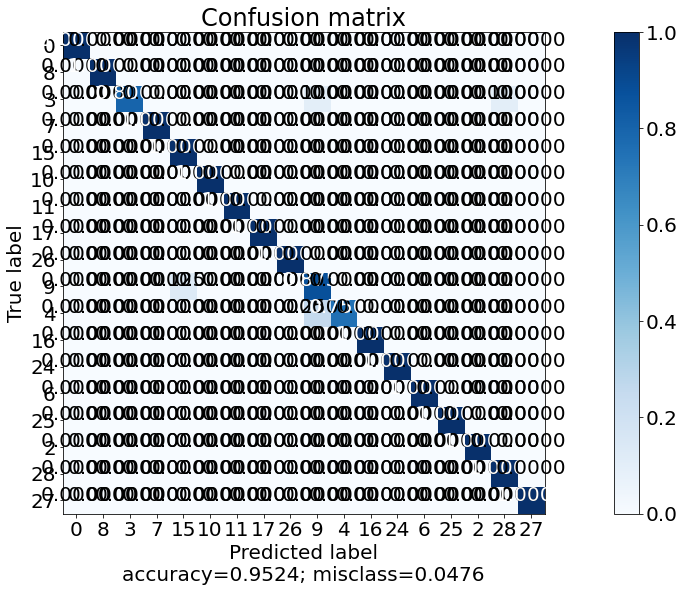

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
11/11 [==============================] - 0s 31ms/step - loss: 0.8800 - output_for_loss: 0.0532 - output_style_loss: 0.0506 - output_win_loss: 0.3426 - output_for_sparse_categorical_accuracy: 0.9849 - output_style_sparse_categorical_accuracy: 0.9789 - output_win_sparse_categorical_accuracy: 0.8852 - val_loss: 1.3921 - val_output_for_loss: 0.0424 - val_output_style_loss: 7.1377e-04 - val_output_win_loss: 0.9223 - val_output_for_sparse_categorical_accuracy: 1.0000 - val_output_style_sparse_categorical_accuracy: 1.0000 - val_output_win_sparse_categorical_accuracy: 0.5000
Epoch 2/100
11/11 [==============================] - 0s 18ms/step - loss: 1.0004 - output_for_loss: 0.0482 - output_style_loss: 0.1250 - output_win_loss: 0.4020 - output_for_sparse_categorical_accuracy: 0.9940 - output_style_sparse_categorical_accuracy: 0.9486 - output_win_sparse_categorical_accuracy: 0.8489 - val_l

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         3
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00        29
          10       1.00      1.00      1.00         4
          11       0.75      1.00      0.86         3
          12       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          17       1.00      1.00      1.00         1
          22       1.00      1.00      1.00         1
          23       1.00      1.00      1.00         1
          25       1.00      1.00      1.00         1
          26       1.00      1.00      1.00         4
          28       1.00      1.00      1.00         5
          30       1.00      1.00      1.00         1

    accuracy              

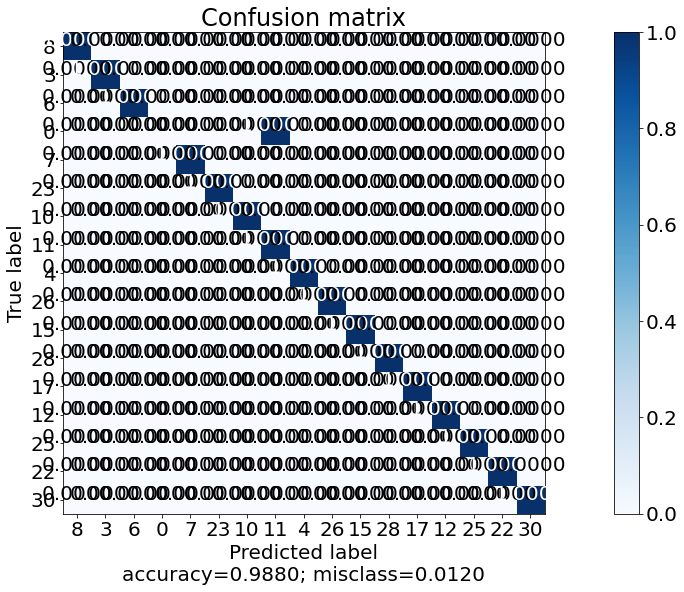

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/100
11/11 [==============================] - 0s 32ms/step - loss: 0.9588 - output_for_loss: 0.0368 - output_style_loss: 0.0889 - output_win_loss: 0.4083 - output_for_sparse_categorical_accuracy: 0.9879 - output_style_sparse_categorical_accuracy: 0.9547 - output_win_sparse_categorical_accuracy: 0.8399 - val_loss: 3.8592 - val_output_for_loss: 0.0053 - val_output_style_loss: 1.8539e-04 - val_output_win_loss: 3.4321 - val_output_for_sparse_categorical_accuracy: 1.0000 - val_output_style_sparse_categorical_accuracy: 1.0000 - val_output_win_sparse_categorical_accuracy: 0.5000
Epoch 2/100
11/11 [==============================] - 0s 19ms/step - loss: 0.8507 - output_for_loss: 0.0348 - output_style_loss: 0.0896 - output_win_loss: 0.3086 - output_for_sparse_categorical_accuracy: 0.9940 - output_style_sparse_categorical_accuracy: 0.9728 - output_win_sparse_categorical_accuracy: 0.8912 - val_l

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      0.97      0.98        32
           9       1.00      1.00      1.00         2
          10       0.80      1.00      0.89         4
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         1
          14       0.00      0.00      0.00         1
          15       0.50      1.00      0.67         1
          17       1.00      1.00      1.00         4
          20       0.00      0.00      0.00         2
          22       0.33      1.00      0.50         1
          25       1.00    

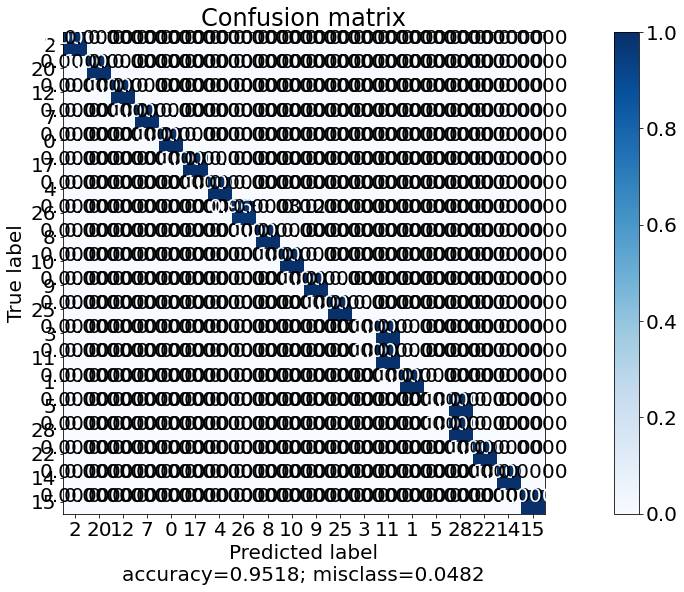



Averages
Accuracy_formation: 0.9308089500860586
Accuracy_style: 0.9067125645438899
Accuracy_win: 0.6870625358577167
Precision_formation: 0.9308089500860586
Precision_style: 0.8986226904870973
Precision_win: 0.6870625358577167
Recall_formation: 0.9308089500860586
Recall_style: 0.9341999463950683
Recall_win: 0.05981067125645438
Style Confusion Matrix

[[39.2  5.2]
 [ 2.6 36.6]]


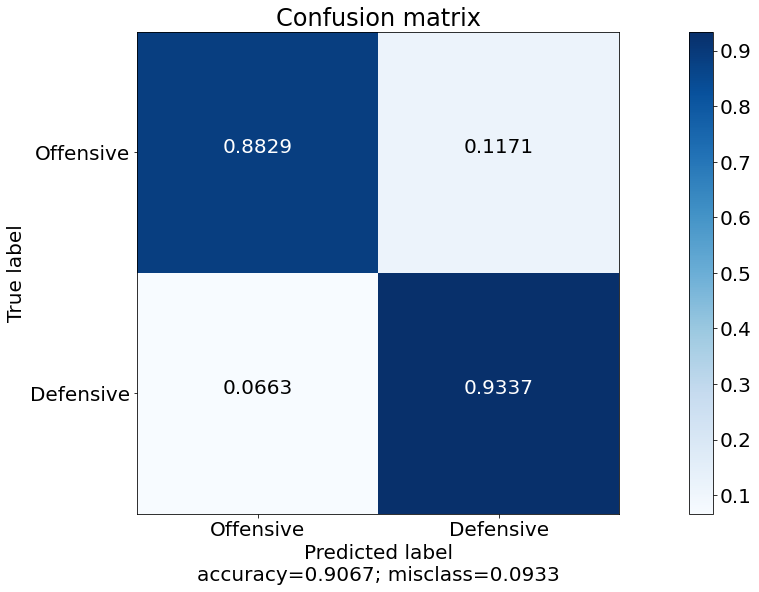

Win Confusion Matrix

[[10.8  7.2  2.8]
 [ 3.4 36.   4.2]
 [ 3.4  5.2 10.6]]


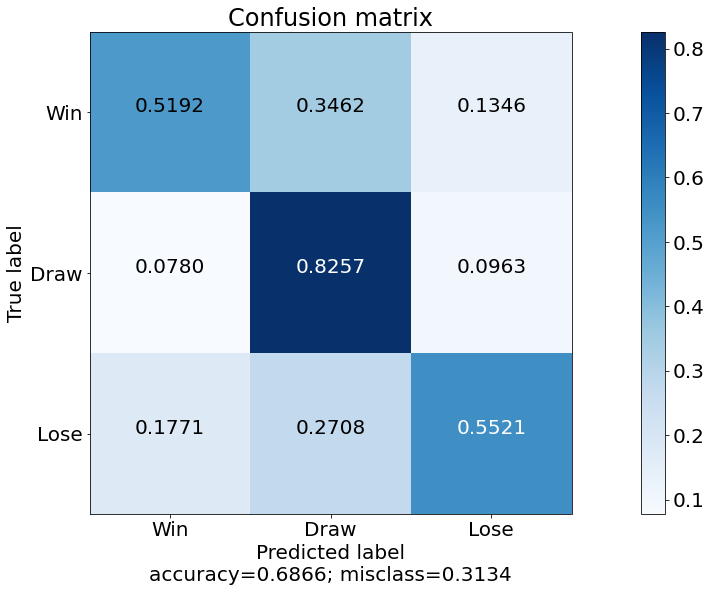

In [275]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

cfmean_for = []
cfmean_style = []
cfmean_win = []
accmean_for = []
accmean_style = []
accmean_win = []
precmean_for = []
precmean_style = []
precmean_win = []
recmean_for = []
recmean_style = []
recmean_win = []



for train, test in kfold.split(x1, y1):
  X_train = x1[train]
  X_test = x1[test]

  X_train_num = X_train[:, :30].astype(np.float)
  X_train_obj = X_train[:, 30:]

  X_test_num = X_test[:, :30].astype(np.float)
  X_test_obj = X_test[:, 30:]

  Y_train = y1[train]
  Y_test = y1[test]



  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(x={
    'FW0': X_train_num[:, 0:1],
    'FW0B':X_train_num[:, 1:2],
    "FW1" :X_train_num[:, 2:3],
    'AMF0':X_train_num[:, 3:4],
    'AMF0B':X_train_num[:, 4:5],
    'AMF1':X_train_num[:, 5:6],
    'AMF1B':X_train_num[:, 6:7],
    'Wing0':X_train_num[:, 7:8],
    'Wing0B':X_train_num[:, 8:9],
    'Wing1':X_train_num[:, 9:10],
    'Wing1B':X_train_num[:, 10:11],
    'CMF0':X_train_num[:, 11:12],
    'CMF0B':X_train_num[:, 12:13],
    'CMF0C':X_train_num[:, 13:14],
    'CMF1':X_train_num[:, 14:15],
    'CMF1B':X_train_num[:, 15:16],
    'DMF0':X_train_num[:, 16:17],
    'DMF1':X_train_num[:, 17:18],
    'DMF1B':X_train_num[:, 18:19],
    'WB0':X_train_num[:, 19:20],
    'WB0B':X_train_num[:, 20:21],
    'WB1':X_train_num[:, 21:22],
    'WB1B':X_train_num[:, 22:23],
    'CB0':X_train_num[:, 23:24],
    'CB0B':X_train_num[:, 24:25],
    'CB1':X_train_num[:, 25:26],
    'CB1B':X_train_num[:, 26:27],
    'GK0':X_train_num[:, 27:28],
    'GK1':X_train_num[:, 28:29],
    'Ball_pos':X_train_num[:, 29:30],

    'Opp_Level':X_train_obj[:, 0:1],
    'Season':X_train_obj[:, 1:2],
    'match_oder':X_train_obj[:, 2:3],
    'oppense_team':X_train_obj[:, 3:4],
    }, 
    y = {'output_for': Y_train[:, 0], 
         'output_style': Y_train[:, 1],
         'output_win':Y_train[:, 2]}, 
         
         epochs=num_epochs, 
         validation_split=0.01 , 
         callbacks=[early_stop])
  

# Generate generalization metrics
  scores = model.evaluate(x={
    'FW0': X_test_num[:, 0:1],
    'FW0B':X_test_num[:, 1:2],
    "FW1" :X_test_num[:, 2:3],
    'AMF0':X_test_num[:, 3:4],
    'AMF0B':X_test_num[:, 4:5],
    'AMF1':X_test_num[:, 5:6],
    'AMF1B':X_test_num[:, 6:7],
    'Wing0':X_test_num[:, 7:8],
    'Wing0B':X_test_num[:, 8:9],
    'Wing1':X_test_num[:, 9:10],
    'Wing1B':X_test_num[:, 10:11],
    'CMF0':X_test_num[:, 11:12],
    'CMF0B':X_test_num[:, 12:13],
    'CMF0C':X_test_num[:, 13:14],
    'CMF1':X_test_num[:, 14:15],
    'CMF1B':X_test_num[:, 15:16],
    'DMF0':X_test_num[:, 16:17],
    'DMF1':X_test_num[:, 17:18],
    'DMF1B':X_test_num[:, 18:19],
    'WB0':X_test_num[:, 19:20],
    'WB0B':X_test_num[:, 20:21],
    'WB1':X_test_num[:, 21:22],
    'WB1B':X_test_num[:, 22:23],
    'CB0':X_test_num[:, 23:24],
    'CB0B':X_test_num[:, 24:25],
    'CB1':X_test_num[:, 25:26],
    'CB1B':X_test_num[:, 26:27],
    'GK0':X_test_num[:, 27:28],
    'GK1':X_test_num[:, 28:29],
    'Ball_pos':X_test_num[:, 29:30],

    'Opp_Level':X_test_obj[:, 0:1],
    'Season':X_test_obj[:, 1:2],
    'match_oder':X_test_obj[:, 2:3],
    'oppense_team':X_test_obj[:, 3:4],
    }, 
    y = {'output_for': Y_test[:, 0], 
         'output_style': Y_test[:, 1],
         'output_win':Y_test[:, 2]})
  

  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[4]} of {scores[4]*100}%; {model.metrics_names[5]} of {scores[5]*100}%\
  ; {model.metrics_names[6]} of {scores[6]*100}%')

  acc_per_fold.append([scores[4] * 100, scores[5] * 100, scores[6] * 100])
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

  y_pred = model.predict(x={
    'FW0': X_test_num[:, 0:1],
    'FW0B':X_test_num[:, 1:2],
    "FW1" :X_test_num[:, 2:3],
    'AMF0':X_test_num[:, 3:4],
    'AMF0B':X_test_num[:, 4:5],
    'AMF1':X_test_num[:, 5:6],
    'AMF1B':X_test_num[:, 6:7],
    'Wing0':X_test_num[:, 7:8],
    'Wing0B':X_test_num[:, 8:9],
    'Wing1':X_test_num[:, 9:10],
    'Wing1B':X_test_num[:, 10:11],
    'CMF0':X_test_num[:, 11:12],
    'CMF0B':X_test_num[:, 12:13],
    'CMF0C':X_test_num[:, 13:14],
    'CMF1':X_test_num[:, 14:15],
    'CMF1B':X_test_num[:, 15:16],
    'DMF0':X_test_num[:, 16:17],
    'DMF1':X_test_num[:, 17:18],
    'DMF1B':X_test_num[:, 18:19],
    'WB0':X_test_num[:, 19:20],
    'WB0B':X_test_num[:, 20:21],
    'WB1':X_test_num[:, 21:22],
    'WB1B':X_test_num[:, 22:23],
    'CB0':X_test_num[:, 23:24],
    'CB0B':X_test_num[:, 24:25],
    'CB1':X_test_num[:, 25:26],
    'CB1B':X_test_num[:, 26:27],
    'GK0':X_test_num[:, 27:28],
    'GK1':X_test_num[:, 28:29],
    'Ball_pos':X_test_num[:, 29:30],

    'Opp_Level':X_test_obj[:, 0:1],
    'Season':X_test_obj[:, 1:2],
    'match_oder':X_test_obj[:, 2:3],
    'oppense_team':X_test_obj[:, 3:4],
    })
  
  pred_for = []
  pred_style = []
  pred_win = []

  for i in y_pred[0:1][0]:
    pred_for.append(argmax(i))

  for i in y_pred[1:2][0]:
    pred_style.append(argmax(i))

  for i in y_pred[2:3][0]:
    pred_win.append(argmax(i))

  
  accmean_for.append(accuracy_score(Y_test[:, 0], pred_for))
  accmean_style.append(accuracy_score(Y_test[:, 1], pred_style))
  accmean_win.append(accuracy_score(Y_test[:, 2], pred_win))

  precmean_for.append(precision_score(Y_test[:, 0], pred_for, average='micro'))
  precmean_style.append(precision_score(Y_test[:, 1], pred_style, average='binary'))
  precmean_win.append(precision_score(Y_test[:, 2], pred_win, average='micro'))

  recmean_for.append(recall_score(Y_test[:, 0], pred_for, average='micro'))
  recmean_style.append(recall_score(Y_test[:, 1], pred_style, average='binary'))
  recmean_win.append(recall_score(Y_test[:, 2], pred_for, average='micro'))

  print(classification_report(Y_test[:, 0], pred_for, ))
  print(classification_report(Y_test[:, 1], pred_style, ))
  print(classification_report(Y_test[:, 2], pred_win, ))

  cfmean_for.append(confusion_matrix(Y_test[:, 0], pred_for))
  cfmean_style.append(confusion_matrix(Y_test[:, 1], pred_style))
  cfmean_win.append(confusion_matrix(Y_test[:, 2], pred_win))

  plot_confusion_matrix(confusion_matrix(Y_test[:, 0], pred_for), normalize=True, target_names=pd.Series(Y_test[:, 0]).unique().tolist() )
  #confusion_matrix(Y_test[:, 0], pred_for)


acc_for = np.mean(accmean_for, axis=0)
acc_style = np.mean(accmean_style, axis=0)
acc_win = np.mean(accmean_win, axis=0)

pre_for = np.mean(precmean_for, axis=0)
pre_style = np.mean(precmean_style, axis=0)
pre_win = np.mean(precmean_win, axis=0)

#cm_for = np.mean(cfmean_for, axis=0)
cm_style = np.mean(cfmean_style, axis=0)
cm_win = np.mean(cfmean_win, axis=0)

re_for = np.mean(recmean_for, axis=0)
re_style = np.mean(recmean_style, axis=0)
re_win = np.mean(recmean_win, axis=0)

print('\n')
print("Averages")
print("Accuracy_formation: " + str(acc_for))
print("Accuracy_style: " + str(acc_style))
print("Accuracy_win: " + str(acc_win))

print("Precision_formation: " + str(pre_for))
print("Precision_style: " + str(pre_style))
print("Precision_win: " + str(pre_win))

print("Recall_formation: " + str(re_for))
print("Recall_style: " + str(re_style))
print("Recall_win: " + str(re_win))



print('Style Confusion Matrix\n')
print(cm_style)

plot_confusion_matrix(cm_style, normalize=True, target_names= ['Offensive', 'Defensive'] )

print('Win Confusion Matrix\n')
print(cm_win)

plot_confusion_matrix(cm_win, normalize=True, target_names= ['Win', 'Draw', 'Lose'] )







In [276]:
model.metrics

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
11/11 [==============================] - 6s 145ms/step - loss: 13.7643 - output_for_loss: 6.2328 - output_style_loss: 5.7306 - output_win_loss: 1.4054 - output_for_sparse_categorical_accuracy: 0.2939 - output_style_sparse_categorical_accuracy: 0.6030 - output_win_sparse_categorical_accuracy: 0.3061 - val_loss: 5.8137 - val_output_for_loss: 1.4100 - val_output_style_loss: 2.5995 - val_output_win_loss: 1.3842 - val_output_for_sparse_categorical_accuracy: 0.5000 - val_output_style_sparse_categorical_accuracy: 0.7500 - val_output_win_sparse_categorical_accuracy: 0.2500
Epoch 2/100
11/11 [==============================] - 0s 19ms/step - loss: 3.6290 - output_for_loss: 1.6292 - output_style_loss: 0.4221 - output_win_loss: 1.1387 - output_for_sparse_categorical_accuracy: 0.6152 - output_style_sparse_categorical_accuracy: 0.8394 - output_win_sparse_categorical_accuracy: 0.4212 - val_los

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         6
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       0.97      1.00      0.98        31
           9       0.75      1.00      0.86         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      0.33      0.50         3
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         1
          17       1.00      1.00      1.00         1
          22       1.00    

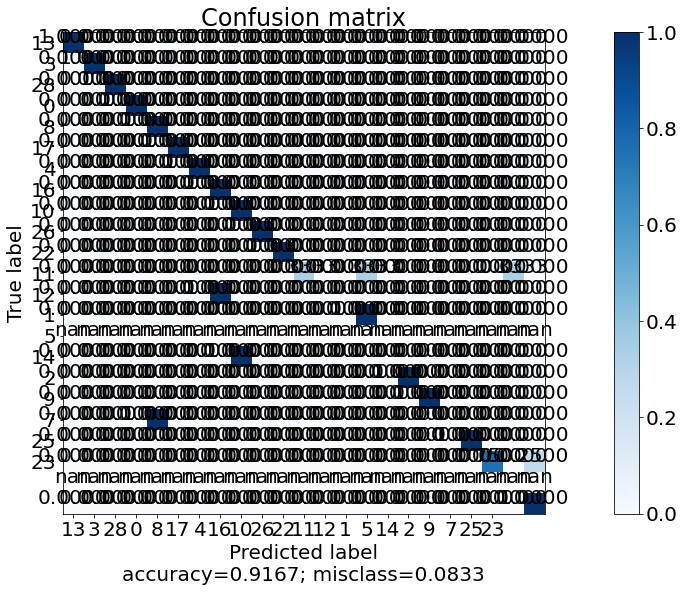

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
11/11 [==============================] - 0s 33ms/step - loss: 1.6406 - output_for_loss: 0.3057 - output_style_loss: 0.1861 - output_win_loss: 0.7687 - output_for_sparse_categorical_accuracy: 0.9636 - output_style_sparse_categorical_accuracy: 0.9394 - output_win_sparse_categorical_accuracy: 0.7000 - val_loss: 14.9011 - val_output_for_loss: 0.0288 - val_output_style_loss: 12.3981 - val_output_win_loss: 2.0857 - val_output_for_sparse_categorical_accuracy: 1.0000 - val_output_style_sparse_categorical_accuracy: 0.2500 - val_output_win_sparse_categorical_accuracy: 0.5000
Epoch 2/100
11/11 [==============================] - 0s 21ms/step - loss: 1.4477 - output_for_loss: 0.1474 - output_style_loss: 0.1218 - output_win_loss: 0.7800 - output_for_sparse_categorical_accuracy: 0.9636 - output_style_sparse_categorical_accuracy: 0.9667 - output_win_sparse_categorical_accuracy: 0.6818 - val_los

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         2
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4
           8       0.96      1.00      0.98        26
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00         2
          11       1.00      0.86      0.92         7
          15       1.00      1.00      1.00         2
          16       0.00      0.00      0.00         0
          17       0.67      1.00      0.80         2
          19       1.00      1.00      1.00         1
          26       1.00      1.00      1.00         1
          27       1.00      1.00      1.00         1
          28       0.75      1.00      0.86         3
          30       0.00      0.00      0.00         1

    accuracy              

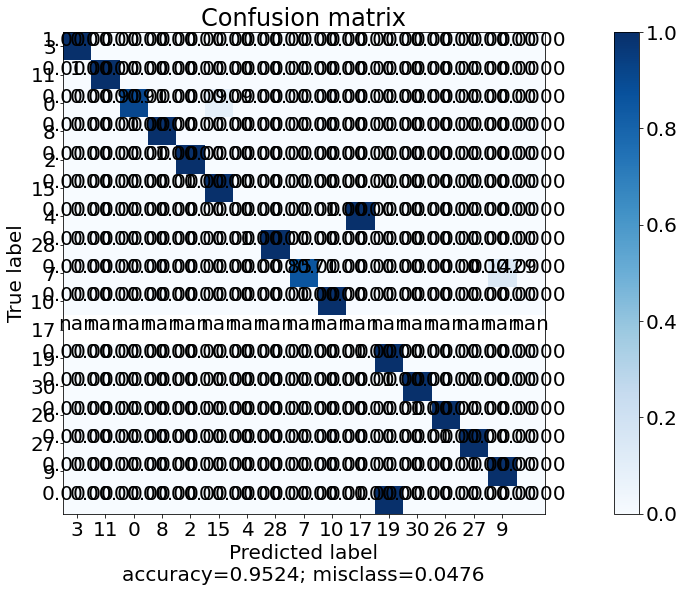

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
11/11 [==============================] - 0s 33ms/step - loss: 1.3388 - output_for_loss: 0.0941 - output_style_loss: 0.1635 - output_win_loss: 0.6330 - output_for_sparse_categorical_accuracy: 0.9818 - output_style_sparse_categorical_accuracy: 0.9394 - output_win_sparse_categorical_accuracy: 0.7455 - val_loss: 4.5046 - val_output_for_loss: 0.3619 - val_output_style_loss: 3.3340 - val_output_win_loss: 0.3687 - val_output_for_sparse_categorical_accuracy: 0.7500 - val_output_style_sparse_categorical_accuracy: 0.2500 - val_output_win_sparse_categorical_accuracy: 0.7500
Epoch 2/100
11/11 [==============================] - 0s 18ms/step - loss: 1.1774 - output_for_loss: 0.0651 - output_style_loss: 0.0849 - output_win_loss: 0.5939 - output_for_sparse_categorical_accuracy: 0.9727 - output_style_sparse_categorical_accuracy: 0.9636 - output_win_sparse_categorical_accuracy: 0.7576 - val_loss:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         2
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00        38
           9       0.50      1.00      0.67         1
          10       1.00      1.00      1.00         2
          11       0.86      1.00      0.92         6
          12       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          17       1.00      1.00      1.00         1
          21       0.00      0.00      0.00         1
          22       0.50      1.00      0.67         1
          25       1.00    

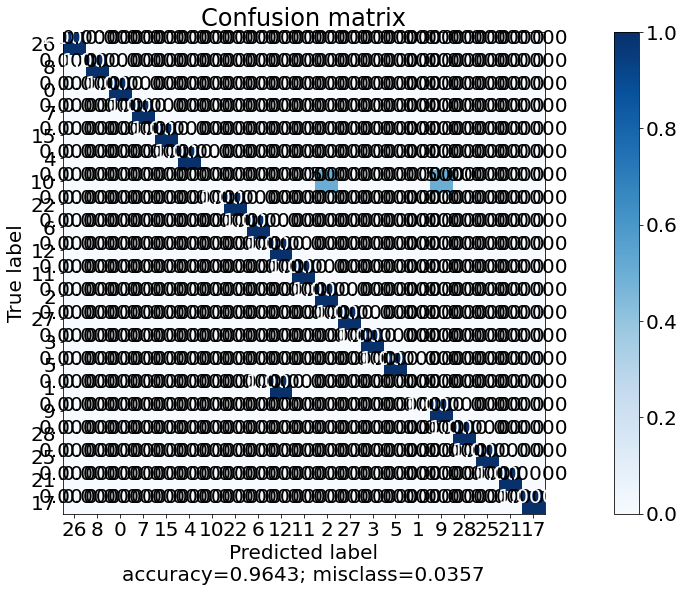

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
11/11 [==============================] - 0s 33ms/step - loss: 1.2228 - output_for_loss: 0.0953 - output_style_loss: 0.1276 - output_win_loss: 0.5712 - output_for_sparse_categorical_accuracy: 0.9758 - output_style_sparse_categorical_accuracy: 0.9517 - output_win_sparse_categorical_accuracy: 0.7734 - val_loss: 7.2599 - val_output_for_loss: 7.1794e-04 - val_output_style_loss: 3.8537 - val_output_win_loss: 2.9773 - val_output_for_sparse_categorical_accuracy: 1.0000 - val_output_style_sparse_categorical_accuracy: 0.7500 - val_output_win_sparse_categorical_accuracy: 0.2500
Epoch 2/100
11/11 [==============================] - 0s 22ms/step - loss: 1.1094 - output_for_loss: 0.0445 - output_style_loss: 0.1049 - output_win_loss: 0.5313 - output_for_sparse_categorical_accuracy: 0.9879 - output_style_sparse_categorical_accuracy: 0.9456 - output_win_sparse_categorical_accuracy: 0.8036 - val_l

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           2       1.00      1.00      1.00         3
           3       0.82      1.00      0.90         9
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         2
           8       1.00      0.93      0.96        29
          10       1.00      1.00      1.00         7
          11       0.50      0.50      0.50         2
          14       0.00      0.00      0.00         0
          15       1.00      1.00      1.00         2
          17       1.00      1.00      1.00         2
          19       0.00      0.00      0.00         1
          20       1.00      1.00      1.00         1
          22       1.00      1.00      1.00         1
          24       0.50      1.00      0.67         1
          25       1.00    

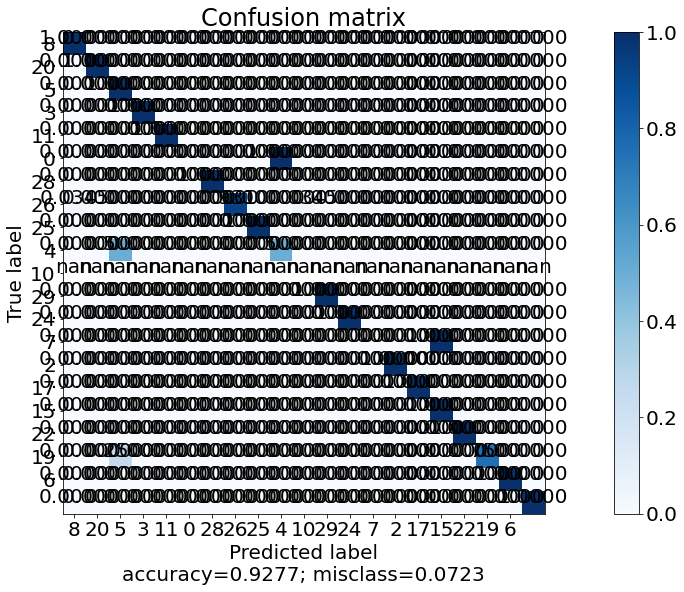

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/100
11/11 [==============================] - 0s 33ms/step - loss: 1.2284 - output_for_loss: 0.0714 - output_style_loss: 0.1224 - output_win_loss: 0.6398 - output_for_sparse_categorical_accuracy: 0.9819 - output_style_sparse_categorical_accuracy: 0.9517 - output_win_sparse_categorical_accuracy: 0.7885 - val_loss: 5.6218 - val_output_for_loss: 0.2224 - val_output_style_loss: 4.9632 - val_output_win_loss: 0.0456 - val_output_for_sparse_categorical_accuracy: 0.7500 - val_output_style_sparse_categorical_accuracy: 0.5000 - val_output_win_sparse_categorical_accuracy: 1.0000
Epoch 2/100
11/11 [==============================] - 0s 20ms/step - loss: 1.0121 - output_for_loss: 0.0709 - output_style_loss: 0.1020 - output_win_loss: 0.4485 - output_for_sparse_categorical_accuracy: 0.9758 - output_style_sparse_categorical_accuracy: 0.9577 - output_win_sparse_categorical_accuracy: 0.8308 - val_loss:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         1
           3       0.88      1.00      0.93         7
           4       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00        26
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         2
          12       1.00      0.50      0.67         2
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         1
          17       0.80      1.00      0.89         4
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         0
          20       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         2
          25       1.00    

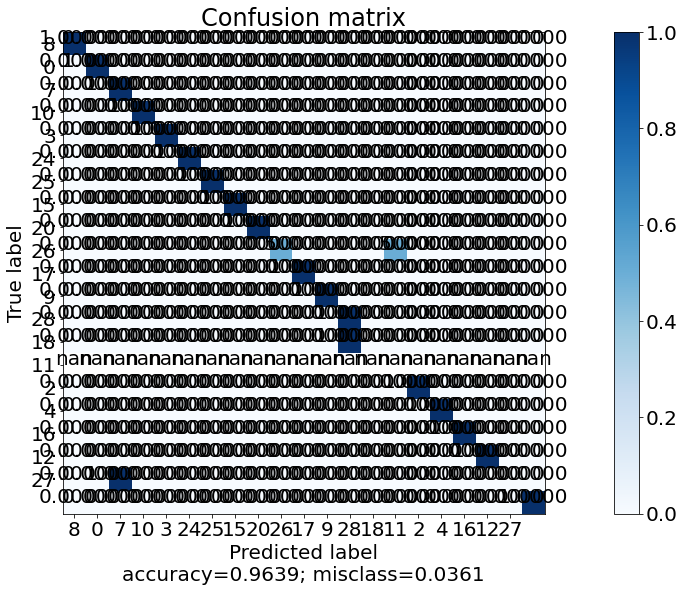



Averages
Accuracy_formation: 0.9449799196787149
Accuracy_style: 0.8877510040160643
Accuracy_win: 0.6099827882960414
Precision_formation: 0.9449799196787149
Precision_style: 0.902800630741807
Precision_win: 0.6099827882960414
Recall_formation: 0.9449799196787149
Recall_style: 0.8719230769230769
Recall_win: 0.062162937464142275
Style Confusion Matrix

[[40.   4.4]
 [ 5.  34.2]]


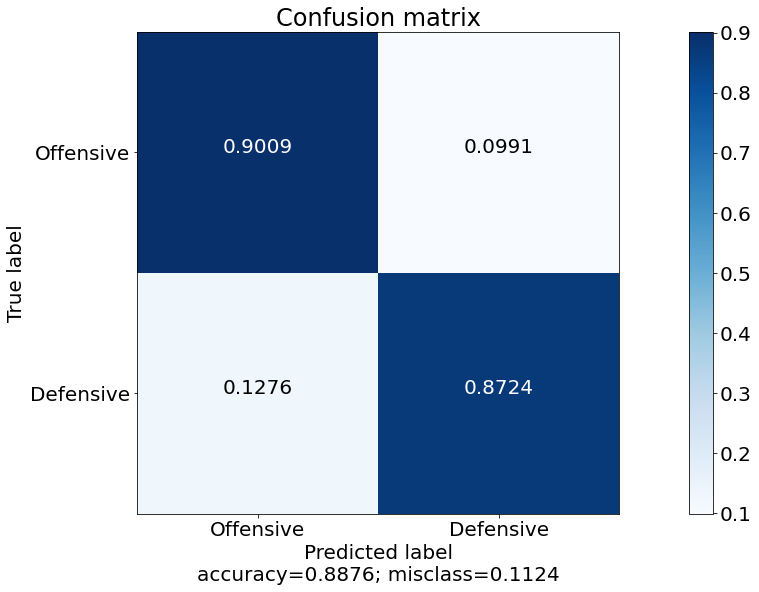

Win Confusion Matrix

[[ 5.8 12.6  2.4]
 [ 2.  38.6  3. ]
 [ 2.4 10.2  6.6]]


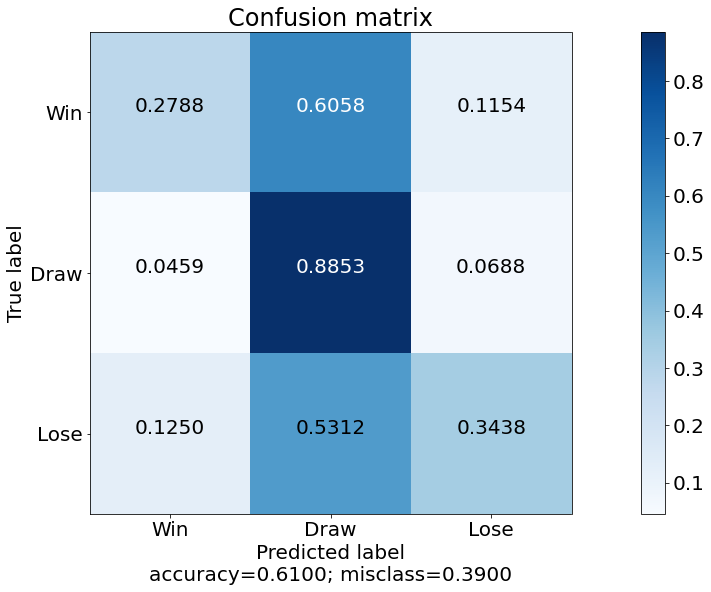

In [298]:
#### Stratified K-fold Cross-Validation

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold


dataframe1 = dataframe[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'Ball_pos']].astype(np.float)

dataframe2 = dataframe[['Opp_Level', 'Season','match_oder', 'oppense_team', 'Formation', 'Style', 'Win']]
df_cat = pd.concat([dataframe1, dataframe2], axis=1)

x1 = df_cat.drop(['Formation', 'Style', 'Win'], axis=1).values
y1 = df_cat[['Formation', 'Style', 'Win']].values

model = create_model(encoding_size=encoding_size) 

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
            loss= {'output_for': keras.losses.SparseCategoricalCrossentropy(), 
                    'output_win':keras.losses.SparseCategoricalCrossentropy(), 
                    'output_style':keras.losses.SparseCategoricalCrossentropy()},
            metrics =  {'output_for': [keras.metrics.SparseCategoricalAccuracy()],
                    'output_win':[keras.metrics.SparseCategoricalAccuracy()], 
                    'output_style':[keras.metrics.SparseCategoricalAccuracy()] })


num_folds = 5
skfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
fold_no = 1
acc_per_skfold = []
loss_per_skfold = []

cfmean_for = []
cfmean_style = []
cfmean_win = []
accmean_for = []
accmean_style = []
accmean_win = []
precmean_for = []
precmean_style = []
precmean_win = []
recmean_for = []
recmean_style = []
recmean_win = []



for train, test in skfold.split(x1, y1[:, 1]):
  X_train = x1[train]
  X_test = x1[test]

  X_train_num = X_train[:, :30].astype(np.float)
  X_train_obj = X_train[:, 30:]

  X_test_num = X_test[:, :30].astype(np.float)
  X_test_obj = X_test[:, 30:]

  Y_train = y1[train]
  Y_test = y1[test]



  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(x={
    'FW0': X_train_num[:, 0:1],
    'FW0B':X_train_num[:, 1:2],
    "FW1" :X_train_num[:, 2:3],
    'AMF0':X_train_num[:, 3:4],
    'AMF0B':X_train_num[:, 4:5],
    'AMF1':X_train_num[:, 5:6],
    'AMF1B':X_train_num[:, 6:7],
    'Wing0':X_train_num[:, 7:8],
    'Wing0B':X_train_num[:, 8:9],
    'Wing1':X_train_num[:, 9:10],
    'Wing1B':X_train_num[:, 10:11],
    'CMF0':X_train_num[:, 11:12],
    'CMF0B':X_train_num[:, 12:13],
    'CMF0C':X_train_num[:, 13:14],
    'CMF1':X_train_num[:, 14:15],
    'CMF1B':X_train_num[:, 15:16],
    'DMF0':X_train_num[:, 16:17],
    'DMF1':X_train_num[:, 17:18],
    'DMF1B':X_train_num[:, 18:19],
    'WB0':X_train_num[:, 19:20],
    'WB0B':X_train_num[:, 20:21],
    'WB1':X_train_num[:, 21:22],
    'WB1B':X_train_num[:, 22:23],
    'CB0':X_train_num[:, 23:24],
    'CB0B':X_train_num[:, 24:25],
    'CB1':X_train_num[:, 25:26],
    'CB1B':X_train_num[:, 26:27],
    'GK0':X_train_num[:, 27:28],
    'GK1':X_train_num[:, 28:29],
    'Ball_pos':X_train_num[:, 29:30],

    'Opp_Level':X_train_obj[:, 0:1],
    'Season':X_train_obj[:, 1:2],
    'match_oder':X_train_obj[:, 2:3],
    'oppense_team':X_train_obj[:, 3:4],
    }, 
    y = {'output_for': Y_train[:, 0], 
         'output_style': Y_train[:, 1],
         'output_win':Y_train[:, 2]}, 
         
         epochs=num_epochs, 
         validation_split=0.01 , 
         callbacks=[early_stop])
  

# Generate generalization metrics
  scores = model.evaluate(x={
    'FW0': X_test_num[:, 0:1],
    'FW0B':X_test_num[:, 1:2],
    "FW1" :X_test_num[:, 2:3],
    'AMF0':X_test_num[:, 3:4],
    'AMF0B':X_test_num[:, 4:5],
    'AMF1':X_test_num[:, 5:6],
    'AMF1B':X_test_num[:, 6:7],
    'Wing0':X_test_num[:, 7:8],
    'Wing0B':X_test_num[:, 8:9],
    'Wing1':X_test_num[:, 9:10],
    'Wing1B':X_test_num[:, 10:11],
    'CMF0':X_test_num[:, 11:12],
    'CMF0B':X_test_num[:, 12:13],
    'CMF0C':X_test_num[:, 13:14],
    'CMF1':X_test_num[:, 14:15],
    'CMF1B':X_test_num[:, 15:16],
    'DMF0':X_test_num[:, 16:17],
    'DMF1':X_test_num[:, 17:18],
    'DMF1B':X_test_num[:, 18:19],
    'WB0':X_test_num[:, 19:20],
    'WB0B':X_test_num[:, 20:21],
    'WB1':X_test_num[:, 21:22],
    'WB1B':X_test_num[:, 22:23],
    'CB0':X_test_num[:, 23:24],
    'CB0B':X_test_num[:, 24:25],
    'CB1':X_test_num[:, 25:26],
    'CB1B':X_test_num[:, 26:27],
    'GK0':X_test_num[:, 27:28],
    'GK1':X_test_num[:, 28:29],
    'Ball_pos':X_test_num[:, 29:30],

    'Opp_Level':X_test_obj[:, 0:1],
    'Season':X_test_obj[:, 1:2],
    'match_oder':X_test_obj[:, 2:3],
    'oppense_team':X_test_obj[:, 3:4],
    }, 
    y = {'output_for': Y_test[:, 0], 
         'output_style': Y_test[:, 1],
         'output_win':Y_test[:, 2]})
  

  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[4]} of {scores[4]*100}%; {model.metrics_names[5]} of {scores[5]*100}%\
  ; {model.metrics_names[6]} of {scores[6]*100}%')

  acc_per_skfold.append([scores[4] * 100, scores[5] * 100, scores[6] * 100])
  loss_per_skfold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

  y_pred = model.predict(x={
    'FW0': X_test_num[:, 0:1],
    'FW0B':X_test_num[:, 1:2],
    "FW1" :X_test_num[:, 2:3],
    'AMF0':X_test_num[:, 3:4],
    'AMF0B':X_test_num[:, 4:5],
    'AMF1':X_test_num[:, 5:6],
    'AMF1B':X_test_num[:, 6:7],
    'Wing0':X_test_num[:, 7:8],
    'Wing0B':X_test_num[:, 8:9],
    'Wing1':X_test_num[:, 9:10],
    'Wing1B':X_test_num[:, 10:11],
    'CMF0':X_test_num[:, 11:12],
    'CMF0B':X_test_num[:, 12:13],
    'CMF0C':X_test_num[:, 13:14],
    'CMF1':X_test_num[:, 14:15],
    'CMF1B':X_test_num[:, 15:16],
    'DMF0':X_test_num[:, 16:17],
    'DMF1':X_test_num[:, 17:18],
    'DMF1B':X_test_num[:, 18:19],
    'WB0':X_test_num[:, 19:20],
    'WB0B':X_test_num[:, 20:21],
    'WB1':X_test_num[:, 21:22],
    'WB1B':X_test_num[:, 22:23],
    'CB0':X_test_num[:, 23:24],
    'CB0B':X_test_num[:, 24:25],
    'CB1':X_test_num[:, 25:26],
    'CB1B':X_test_num[:, 26:27],
    'GK0':X_test_num[:, 27:28],
    'GK1':X_test_num[:, 28:29],
    'Ball_pos':X_test_num[:, 29:30],

    'Opp_Level':X_test_obj[:, 0:1],
    'Season':X_test_obj[:, 1:2],
    'match_oder':X_test_obj[:, 2:3],
    'oppense_team':X_test_obj[:, 3:4],
    })
  
  pred_for = []
  pred_style = []
  pred_win = []

  for i in y_pred[0:1][0]:
    pred_for.append(argmax(i))

  for i in y_pred[1:2][0]:
    pred_style.append(argmax(i))

  for i in y_pred[2:3][0]:
    pred_win.append(argmax(i))

  
  accmean_for.append(accuracy_score(Y_test[:, 0], pred_for))
  accmean_style.append(accuracy_score(Y_test[:, 1], pred_style))
  accmean_win.append(accuracy_score(Y_test[:, 2], pred_win))

  precmean_for.append(precision_score(Y_test[:, 0], pred_for, average='micro'))
  precmean_style.append(precision_score(Y_test[:, 1], pred_style, average='binary'))
  precmean_win.append(precision_score(Y_test[:, 2], pred_win, average='micro'))

  recmean_for.append(recall_score(Y_test[:, 0], pred_for, average='micro'))
  recmean_style.append(recall_score(Y_test[:, 1], pred_style, average='binary'))
  recmean_win.append(recall_score(Y_test[:, 2], pred_for, average='micro'))

  print(classification_report(Y_test[:, 0], pred_for, ))
  print(classification_report(Y_test[:, 1], pred_style, ))
  print(classification_report(Y_test[:, 2], pred_win, ))

  cfmean_for.append(confusion_matrix(Y_test[:, 0], pred_for))
  cfmean_style.append(confusion_matrix(Y_test[:, 1], pred_style))
  cfmean_win.append(confusion_matrix(Y_test[:, 2], pred_win))

  plot_confusion_matrix(confusion_matrix(Y_test[:, 0], pred_for), normalize=True, target_names=pd.Series(Y_test[:, 0]).unique().tolist() )
  #confusion_matrix(Y_test[:, 0], pred_for)


acc_for = np.mean(accmean_for, axis=0)
acc_style = np.mean(accmean_style, axis=0)
acc_win = np.mean(accmean_win, axis=0)

pre_for = np.mean(precmean_for, axis=0)
pre_style = np.mean(precmean_style, axis=0)
pre_win = np.mean(precmean_win, axis=0)

#cm_for = np.mean(cfmean_for, axis=0)
cm_style = np.mean(cfmean_style, axis=0)
cm_win = np.mean(cfmean_win, axis=0)

re_for = np.mean(recmean_for, axis=0)
re_style = np.mean(recmean_style, axis=0)
re_win = np.mean(recmean_win, axis=0)

print('\n')
print("Averages")
print("Accuracy_formation: " + str(acc_for))
print("Accuracy_style: " + str(acc_style))
print("Accuracy_win: " + str(acc_win))

print("Precision_formation: " + str(pre_for))
print("Precision_style: " + str(pre_style))
print("Precision_win: " + str(pre_win))

print("Recall_formation: " + str(re_for))
print("Recall_style: " + str(re_style))
print("Recall_win: " + str(re_win))



print('Style Confusion Matrix\n')
print(cm_style)

plot_confusion_matrix(cm_style, normalize=True, target_names= ['Offensive', 'Defensive'] )

print('Win Confusion Matrix\n')
print(cm_win)

plot_confusion_matrix(cm_win, normalize=True, target_names= ['Win', 'Draw', 'Lose'] )



------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
11/11 [==============================] - 5s 113ms/step - loss: 11.5563 - output_for_loss: 4.9840 - output_style_loss: 5.0073 - output_win_loss: 1.1694 - output_for_sparse_categorical_accuracy: 0.2545 - output_style_sparse_categorical_accuracy: 0.5939 - output_win_sparse_categorical_accuracy: 0.3909 - val_loss: 4.1454 - val_output_for_loss: 1.9912 - val_output_style_loss: 1.0356 - val_output_win_loss: 0.6951 - val_output_for_sparse_categorical_accuracy: 0.5000 - val_output_style_sparse_categorical_accuracy: 0.5000 - val_output_win_sparse_categorical_accuracy: 0.7500
Epoch 2/100
11/11 [==============================] - 0s 15ms/step - loss: 3.7559 - output_for_loss: 1.5959 - output_style_loss: 0.6505 - output_win_loss: 1.0649 - output_for_sparse_categorical_accuracy: 0.6364 - output_style_sparse_categorical_accuracy: 0.7576 - output_win_sparse_categorical_accuracy: 0.4606 - val_los

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           2       1.00      0.50      0.67         2
           3       1.00      0.57      0.73         7
           4       0.50      1.00      0.67         2
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         3
           8       0.96      0.96      0.96        27
           9       0.50      1.00      0.67         1
          10       1.00      1.00      1.00         3
          11       1.00      0.75      0.86         4
          12       0.40      1.00      0.57         2
          15       1.00      1.00      1.00         4
          17       1.00      1.00      1.00         2
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          22       1.00      1.00      1.00         1
          25       1.00      0.50      0.67         2
          26       1.00    

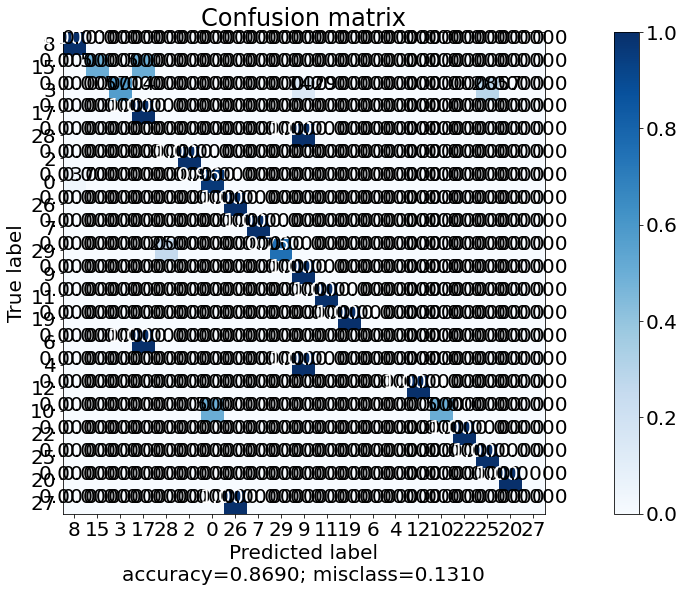

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
11/11 [==============================] - 0s 31ms/step - loss: 1.4004 - output_for_loss: 0.2091 - output_style_loss: 0.0797 - output_win_loss: 0.6874 - output_for_sparse_categorical_accuracy: 0.9606 - output_style_sparse_categorical_accuracy: 0.9758 - output_win_sparse_categorical_accuracy: 0.7606 - val_loss: 3.0899 - val_output_for_loss: 0.0354 - val_output_style_loss: 0.0059 - val_output_win_loss: 2.6255 - val_output_for_sparse_categorical_accuracy: 1.0000 - val_output_style_sparse_categorical_accuracy: 1.0000 - val_output_win_sparse_categorical_accuracy: 0.5000
Epoch 2/100
11/11 [==============================] - 0s 18ms/step - loss: 1.2691 - output_for_loss: 0.0762 - output_style_loss: 0.1511 - output_win_loss: 0.6169 - output_for_sparse_categorical_accuracy: 0.9879 - output_style_sparse_categorical_accuracy: 0.9485 - output_win_sparse_categorical_accuracy: 0.7606 - val_loss:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         2
           6       0.00      0.00      0.00         1
           7       0.50      1.00      0.67         1
           8       1.00      1.00      1.00        34
           9       0.67      1.00      0.80         2
          10       1.00      1.00      1.00         4
          11       0.71      0.83      0.77         6
          12       1.00      1.00      1.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         1
          17       1.00      1.00      1.00         2
          23       1.00      1.00      1.00         1
          25       1.00      1.00      1.00         1
          26       1.00    

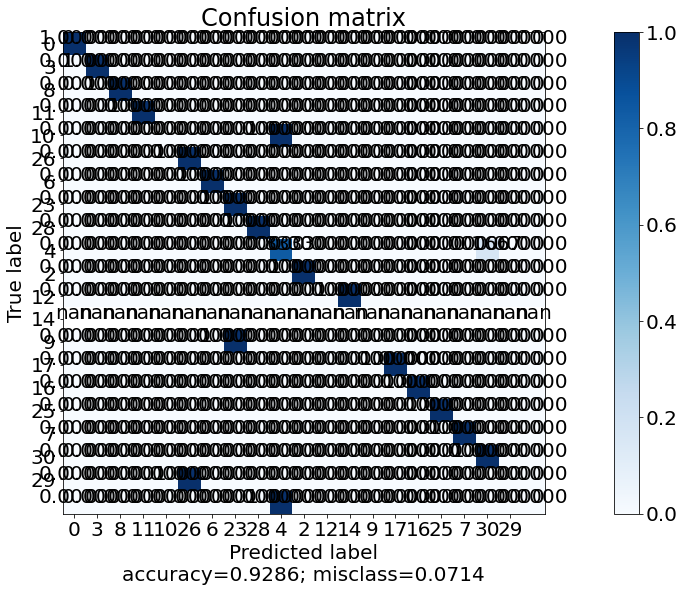

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
11/11 [==============================] - 0s 32ms/step - loss: 1.3331 - output_for_loss: 0.2006 - output_style_loss: 0.1721 - output_win_loss: 0.5561 - output_for_sparse_categorical_accuracy: 0.9727 - output_style_sparse_categorical_accuracy: 0.9394 - output_win_sparse_categorical_accuracy: 0.8091 - val_loss: 7.0031 - val_output_for_loss: 0.2106 - val_output_style_loss: 5.2822 - val_output_win_loss: 1.0985 - val_output_for_sparse_categorical_accuracy: 1.0000 - val_output_style_sparse_categorical_accuracy: 0.0000e+00 - val_output_win_sparse_categorical_accuracy: 0.2500
Epoch 2/100
11/11 [==============================] - 0s 19ms/step - loss: 1.1716 - output_for_loss: 0.1025 - output_style_loss: 0.1510 - output_win_loss: 0.4989 - output_for_sparse_categorical_accuracy: 0.9697 - output_style_sparse_categorical_accuracy: 0.9152 - output_win_sparse_categorical_accuracy: 0.8000 - val_l

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           6       0.00      0.00      0.00         0
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00        35
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          17       1.00      1.00      1.00         1
          18       0.00      0.00      0.00         1
          19       1.00      1.00      1.00         1
          23       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         1
          26       0.00    

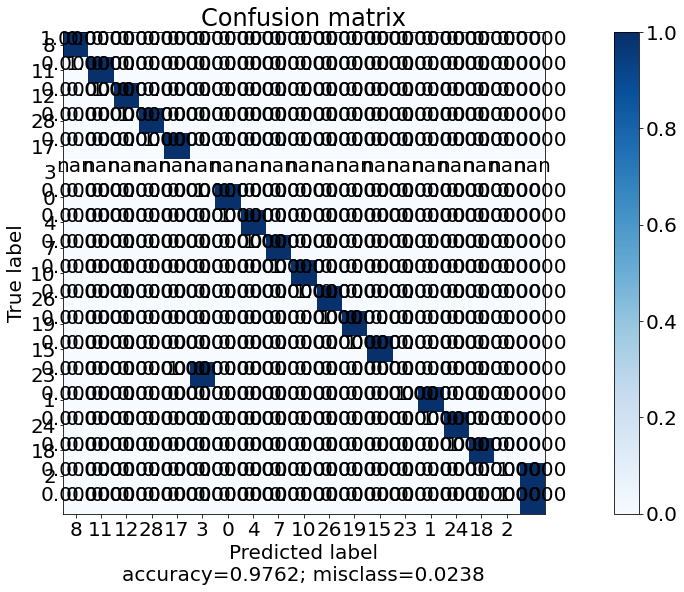

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
11/11 [==============================] - 0s 33ms/step - loss: 1.2423 - output_for_loss: 0.0708 - output_style_loss: 0.1287 - output_win_loss: 0.6149 - output_for_sparse_categorical_accuracy: 0.9848 - output_style_sparse_categorical_accuracy: 0.9485 - output_win_sparse_categorical_accuracy: 0.7576 - val_loss: 6.1348 - val_output_for_loss: 0.7738 - val_output_style_loss: 3.1554 - val_output_win_loss: 1.7755 - val_output_for_sparse_categorical_accuracy: 0.7500 - val_output_style_sparse_categorical_accuracy: 0.5000 - val_output_win_sparse_categorical_accuracy: 0.7500
Epoch 2/100
11/11 [==============================] - 0s 18ms/step - loss: 1.3354 - output_for_loss: 0.1339 - output_style_loss: 0.2113 - output_win_loss: 0.5581 - output_for_sparse_categorical_accuracy: 0.9576 - output_style_sparse_categorical_accuracy: 0.9061 - output_win_sparse_categorical_accuracy: 0.7545 - val_loss:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       0.69      0.58      0.63        19
           1       0.77      0.94      0.85        50
           2       0.86      0.40      0.55        15

    accuracy                           0.76        84
   macro avg       0.77      0.64      0.67        84
weighted avg       0.77      0.76      0.74        84



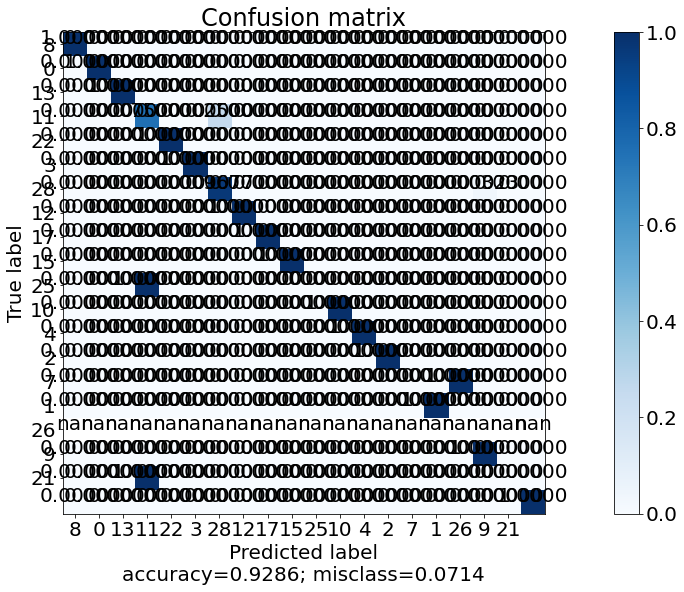

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/100
11/11 [==============================] - 0s 32ms/step - loss: 1.0307 - output_for_loss: 0.0722 - output_style_loss: 0.0866 - output_win_loss: 0.4559 - output_for_sparse_categorical_accuracy: 0.9788 - output_style_sparse_categorical_accuracy: 0.9727 - output_win_sparse_categorical_accuracy: 0.8333 - val_loss: 0.5592 - val_output_for_loss: 0.0063 - val_output_style_loss: 0.0061 - val_output_win_loss: 0.1317 - val_output_for_sparse_categorical_accuracy: 1.0000 - val_output_style_sparse_categorical_accuracy: 1.0000 - val_output_win_sparse_categorical_accuracy: 1.0000
Epoch 2/100
11/11 [==============================] - 0s 19ms/step - loss: 0.9598 - output_for_loss: 0.0421 - output_style_loss: 0.0478 - output_win_loss: 0.4551 - output_for_sparse_categorical_accuracy: 0.9879 - output_style_sparse_categorical_accuracy: 0.9848 - output_win_sparse_categorical_accuracy: 0.8303 - val_loss:

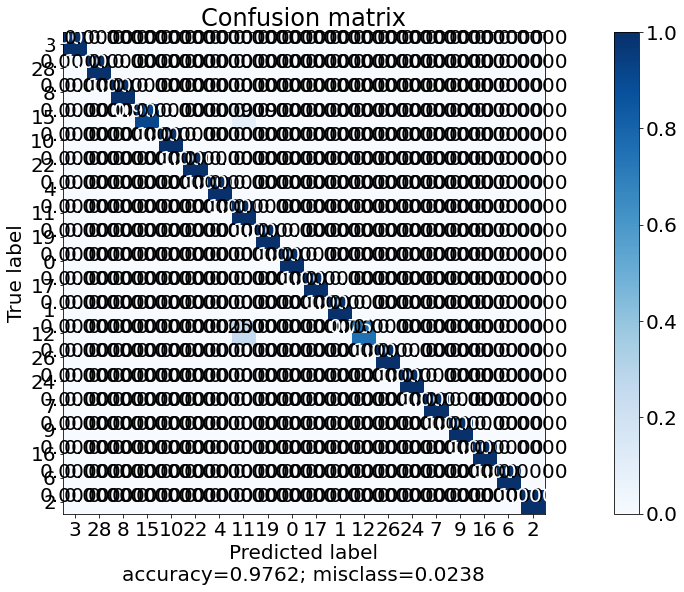



Averages
Accuracy_formation: 0.9357142857142857
Accuracy_style: 0.9095238095238095
Accuracy_win: 0.611904761904762
Precision_formation: 0.9357142857142857
Precision_style: 0.9115510558674151
Precision_win: 0.611904761904762
Recall_formation: 0.9357142857142857
Recall_style: 0.9254541003671971
Recall_win: 0.06666666666666668
Style Confusion Matrix

[[37.   4.6]
 [ 3.  39.4]]


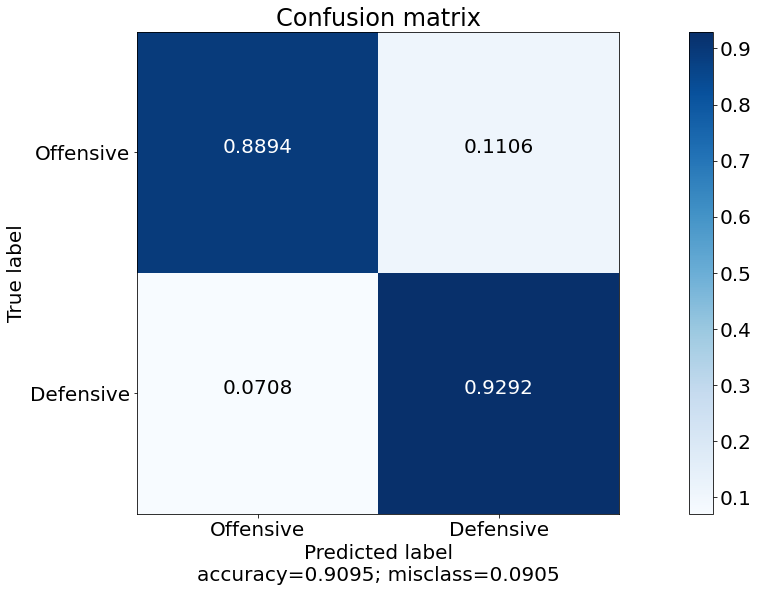

Win Confusion Matrix

[[ 7.2 11.6  0.8]
 [ 2.4 38.8  3.2]
 [ 2.  12.6  5.4]]


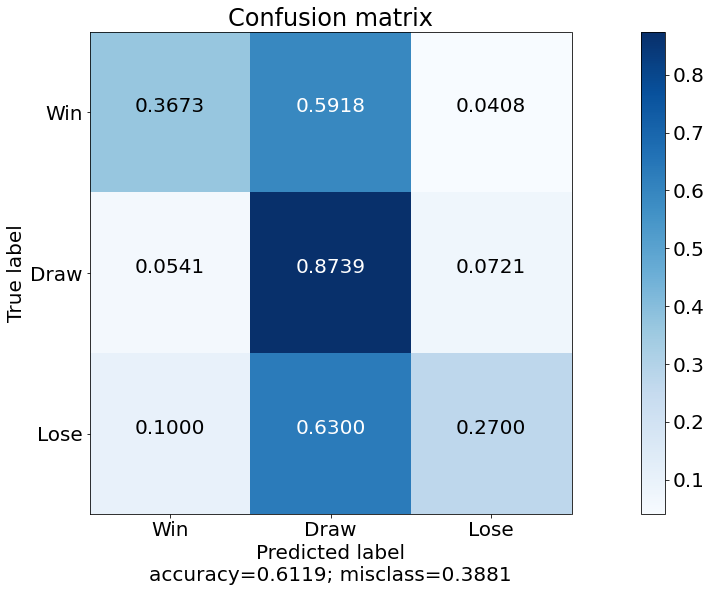

In [296]:
### Repeated Random Test-Train Splits



from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold

cfmean_for = []
cfmean_style = []
cfmean_win = []
accmean_for = []
accmean_style = []
accmean_win = []
precmean_for = []
precmean_style = []
precmean_win = []
recmean_for = []
recmean_style = []
recmean_win = []



dataframe1 = dataframe[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'Ball_pos']].astype(np.float)

dataframe2 = dataframe[['Opp_Level', 'Season','match_oder', 'oppense_team', 'Formation', 'Style', 'Win']]
df_cat = pd.concat([dataframe1, dataframe2], axis=1)

x1 = df_cat.drop(['Formation', 'Style', 'Win'], axis=1).values
y1 = df_cat[['Formation', 'Style', 'Win']].values

model = create_model(encoding_size=encoding_size) 

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
            loss= {'output_for': keras.losses.SparseCategoricalCrossentropy(), 
                    'output_win':keras.losses.SparseCategoricalCrossentropy(), 
                    'output_style':keras.losses.SparseCategoricalCrossentropy()},
            metrics =  {'output_for': [keras.metrics.SparseCategoricalAccuracy()],
                    'output_win':[keras.metrics.SparseCategoricalAccuracy()], 
                    'output_style':[keras.metrics.SparseCategoricalAccuracy()] })


num_folds = 5
shuffle_split = ShuffleSplit(n_splits=5, test_size=0.20, random_state=100)
shfold_no = 1
acc_per_shfold = []
loss_per_shfold = []

for train, test in shuffle_split.split(x1, y1):
  X_train = x1[train]
  X_test = x1[test]

  X_train_num = X_train[:, :30].astype(np.float)
  X_train_obj = X_train[:, 30:]

  X_test_num = X_test[:, :30].astype(np.float)
  X_test_obj = X_test[:, 30:]

  Y_train = y1[train]
  Y_test = y1[test]



  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {shfold_no} ...')

  history = model.fit(x={
    'FW0': X_train_num[:, 0:1],
    'FW0B':X_train_num[:, 1:2],
    "FW1" :X_train_num[:, 2:3],
    'AMF0':X_train_num[:, 3:4],
    'AMF0B':X_train_num[:, 4:5],
    'AMF1':X_train_num[:, 5:6],
    'AMF1B':X_train_num[:, 6:7],
    'Wing0':X_train_num[:, 7:8],
    'Wing0B':X_train_num[:, 8:9],
    'Wing1':X_train_num[:, 9:10],
    'Wing1B':X_train_num[:, 10:11],
    'CMF0':X_train_num[:, 11:12],
    'CMF0B':X_train_num[:, 12:13],
    'CMF0C':X_train_num[:, 13:14],
    'CMF1':X_train_num[:, 14:15],
    'CMF1B':X_train_num[:, 15:16],
    'DMF0':X_train_num[:, 16:17],
    'DMF1':X_train_num[:, 17:18],
    'DMF1B':X_train_num[:, 18:19],
    'WB0':X_train_num[:, 19:20],
    'WB0B':X_train_num[:, 20:21],
    'WB1':X_train_num[:, 21:22],
    'WB1B':X_train_num[:, 22:23],
    'CB0':X_train_num[:, 23:24],
    'CB0B':X_train_num[:, 24:25],
    'CB1':X_train_num[:, 25:26],
    'CB1B':X_train_num[:, 26:27],
    'GK0':X_train_num[:, 27:28],
    'GK1':X_train_num[:, 28:29],
    'Ball_pos':X_train_num[:, 29:30],

    'Opp_Level':X_train_obj[:, 0:1],
    'Season':X_train_obj[:, 1:2],
    'match_oder':X_train_obj[:, 2:3],
    'oppense_team':X_train_obj[:, 3:4],
    }, 
    y = {'output_for': Y_train[:, 0], 
         'output_style': Y_train[:, 1],
         'output_win':Y_train[:, 2]}, 
         
         epochs=num_epochs, 
         validation_split=0.01 , 
         callbacks=[early_stop])
  

# Generate generalization metrics
  scores = model.evaluate(x={
    'FW0': X_test_num[:, 0:1],
    'FW0B':X_test_num[:, 1:2],
    "FW1" :X_test_num[:, 2:3],
    'AMF0':X_test_num[:, 3:4],
    'AMF0B':X_test_num[:, 4:5],
    'AMF1':X_test_num[:, 5:6],
    'AMF1B':X_test_num[:, 6:7],
    'Wing0':X_test_num[:, 7:8],
    'Wing0B':X_test_num[:, 8:9],
    'Wing1':X_test_num[:, 9:10],
    'Wing1B':X_test_num[:, 10:11],
    'CMF0':X_test_num[:, 11:12],
    'CMF0B':X_test_num[:, 12:13],
    'CMF0C':X_test_num[:, 13:14],
    'CMF1':X_test_num[:, 14:15],
    'CMF1B':X_test_num[:, 15:16],
    'DMF0':X_test_num[:, 16:17],
    'DMF1':X_test_num[:, 17:18],
    'DMF1B':X_test_num[:, 18:19],
    'WB0':X_test_num[:, 19:20],
    'WB0B':X_test_num[:, 20:21],
    'WB1':X_test_num[:, 21:22],
    'WB1B':X_test_num[:, 22:23],
    'CB0':X_test_num[:, 23:24],
    'CB0B':X_test_num[:, 24:25],
    'CB1':X_test_num[:, 25:26],
    'CB1B':X_test_num[:, 26:27],
    'GK0':X_test_num[:, 27:28],
    'GK1':X_test_num[:, 28:29],
    'Ball_pos':X_test_num[:, 29:30],

    'Opp_Level':X_test_obj[:, 0:1],
    'Season':X_test_obj[:, 1:2],
    'match_oder':X_test_obj[:, 2:3],
    'oppense_team':X_test_obj[:, 3:4],
    }, 
    y = {'output_for': Y_test[:, 0], 
         'output_style': Y_test[:, 1],
         'output_win':Y_test[:, 2]})
  

  print(f'Score for fold {shfold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[4]} of {scores[4]*100}%; {model.metrics_names[5]} of {scores[5]*100}%\
  ; {model.metrics_names[6]} of {scores[6]*100}%')

  acc_per_shfold.append([scores[4] * 100, scores[5] * 100, scores[6] * 100])
  loss_per_shfold.append(scores[0])

  # Increase fold number
  shfold_no = shfold_no + 1


  y_pred = model.predict(x={
    'FW0': X_test_num[:, 0:1],
    'FW0B':X_test_num[:, 1:2],
    "FW1" :X_test_num[:, 2:3],
    'AMF0':X_test_num[:, 3:4],
    'AMF0B':X_test_num[:, 4:5],
    'AMF1':X_test_num[:, 5:6],
    'AMF1B':X_test_num[:, 6:7],
    'Wing0':X_test_num[:, 7:8],
    'Wing0B':X_test_num[:, 8:9],
    'Wing1':X_test_num[:, 9:10],
    'Wing1B':X_test_num[:, 10:11],
    'CMF0':X_test_num[:, 11:12],
    'CMF0B':X_test_num[:, 12:13],
    'CMF0C':X_test_num[:, 13:14],
    'CMF1':X_test_num[:, 14:15],
    'CMF1B':X_test_num[:, 15:16],
    'DMF0':X_test_num[:, 16:17],
    'DMF1':X_test_num[:, 17:18],
    'DMF1B':X_test_num[:, 18:19],
    'WB0':X_test_num[:, 19:20],
    'WB0B':X_test_num[:, 20:21],
    'WB1':X_test_num[:, 21:22],
    'WB1B':X_test_num[:, 22:23],
    'CB0':X_test_num[:, 23:24],
    'CB0B':X_test_num[:, 24:25],
    'CB1':X_test_num[:, 25:26],
    'CB1B':X_test_num[:, 26:27],
    'GK0':X_test_num[:, 27:28],
    'GK1':X_test_num[:, 28:29],
    'Ball_pos':X_test_num[:, 29:30],

    'Opp_Level':X_test_obj[:, 0:1],
    'Season':X_test_obj[:, 1:2],
    'match_oder':X_test_obj[:, 2:3],
    'oppense_team':X_test_obj[:, 3:4],
    })
  
  pred_for = []
  pred_style = []
  pred_win = []

  for i in y_pred[0:1][0]:
    pred_for.append(argmax(i))

  for i in y_pred[1:2][0]:
    pred_style.append(argmax(i))

  for i in y_pred[2:3][0]:
    pred_win.append(argmax(i))

  
  accmean_for.append(accuracy_score(Y_test[:, 0], pred_for))
  accmean_style.append(accuracy_score(Y_test[:, 1], pred_style))
  accmean_win.append(accuracy_score(Y_test[:, 2], pred_win))

  precmean_for.append(precision_score(Y_test[:, 0], pred_for, average='micro'))
  precmean_style.append(precision_score(Y_test[:, 1], pred_style, average='binary'))
  precmean_win.append(precision_score(Y_test[:, 2], pred_win, average='micro'))

  recmean_for.append(recall_score(Y_test[:, 0], pred_for, average='micro'))
  recmean_style.append(recall_score(Y_test[:, 1], pred_style, average='binary'))
  recmean_win.append(recall_score(Y_test[:, 2], pred_for, average='micro'))

  print(classification_report(Y_test[:, 0], pred_for, ))
  print(classification_report(Y_test[:, 1], pred_style, ))
  print(classification_report(Y_test[:, 2], pred_win, ))

  cfmean_for.append(confusion_matrix(Y_test[:, 0], pred_for))
  cfmean_style.append(confusion_matrix(Y_test[:, 1], pred_style))
  cfmean_win.append(confusion_matrix(Y_test[:, 2], pred_win))

  plot_confusion_matrix(confusion_matrix(Y_test[:, 0], pred_for), normalize=True, target_names=pd.Series(Y_test[:, 0]).unique().tolist() )
  #confusion_matrix(Y_test[:, 0], pred_for)


acc_for = np.mean(accmean_for, axis=0)
acc_style = np.mean(accmean_style, axis=0)
acc_win = np.mean(accmean_win, axis=0)

pre_for = np.mean(precmean_for, axis=0)
pre_style = np.mean(precmean_style, axis=0)
pre_win = np.mean(precmean_win, axis=0)

#cm_for = np.mean(cfmean_for, axis=0)
cm_style = np.mean(cfmean_style, axis=0)
cm_win = np.mean(cfmean_win, axis=0)

re_for = np.mean(recmean_for, axis=0)
re_style = np.mean(recmean_style, axis=0)
re_win = np.mean(recmean_win, axis=0)

print('\n')
print("Averages")
print("Accuracy_formation: " + str(acc_for))
print("Accuracy_style: " + str(acc_style))
print("Accuracy_win: " + str(acc_win))

print("Precision_formation: " + str(pre_for))
print("Precision_style: " + str(pre_style))
print("Precision_win: " + str(pre_win))

print("Recall_formation: " + str(re_for))
print("Recall_style: " + str(re_style))
print("Recall_win: " + str(re_win))



print('Style Confusion Matrix\n')
print(cm_style)

plot_confusion_matrix(cm_style, normalize=True, target_names= ['Offensive', 'Defensive'] )

print('Win Confusion Matrix\n')
print(cm_win)

plot_confusion_matrix(cm_win, normalize=True, target_names= ['Win', 'Draw', 'Lose'] )


In [283]:
# # leave-one-out 방법

# from sklearn.model_selection import LeaveOneOut

# loo = LeaveOneOut()

# for train, test in loo.split(x1, y1):
#     print(train,test)